In [100]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import recall_score

# Dataframes that we have

1. **data** :- original unhampered data frame
2. **datanew** :- Replaced b'0' and b'1' with 0 and 1 also replaced empty cells with NaN
3. **datazero** :- all the data in datanew having target variable 0
4. **dataone** :- all the data in datanew having target variable 1
5. **impu_df_median** :- Data from datanew imputed with median
6. **impu_dzero_median** :- Data from datazero imputed with median
7. **impu_done_median** :- Data from dataone imputed with median
8. **impu_df_mode** :- Data from datanew imputed with mode/most frequent
9. **impu_dzero_mode** :- Data from datazero imputed with mode/most frequent
10. **impu_done_mode** :- Data from dataone imputed with mode/most frequent
11. **df_median_ol_treatment** :- Data from datanew unimputed but replaced outliers with median (tolerance = 1.5)
12. **df_medimp_median_ol_treatment** :- Data from impu_df_median, replaced outliers with median (tolerance = 1.5)
13. **dzero_median_ol_treatment** :- Data from impu_dzero_median, replaced outliers with median (tolerance = 1.5)
14. **done_median_ol_treatment** :- Data from impu_done_median, replaced outliers with median (tolerance = 1.5)
15. **df_modeimp_median_ol_treatment** :- Data from impu_df_mode, replaced outliers with median (tolerance = 1.5)
16. **dzero_modeimp_median_ol_treatment** :- Data from impu_dzero_mode, replaced outliers with median (tolerance = 1.5)
17. **done_modeimp_median_ol_treatment** :- Data from impu_done_mode, replaced outliers with median (tolerance = 1.5)
18. **impu_clas_iso_median** :- Concatenation of impu_dzero_median and impu_done_median
19. **impu_clas_iso_mode** :- Cncatenation of impu_dzero_mode and impu_done_mode
20. **clas_iso_median_ol_treatment** :- Concatenation of dzero_median_ol_treatment and done_median_ol_treatment
21. **clas_iso_modeimp_median_ol_treatment** :- Concatenaton of dzero_modeimp_median_ol_treatment and done_modeimp_median_ol_treatment

# Important Functions
To reduce redundant code

### 1. Function to gropu variables as per the correlation

In [2]:
# Function to findout the correlation groups with correlation above or below the tol_corr value
def corr_group(correlation, tol_corr):
    corr_pairs = correlation.unstack()
    high_corr = corr_pairs[(corr_pairs>=tol_corr) | (corr_pairs<=(-1)*tol_corr)]
    print(high_corr)

### 2. To calculate median, upper and lower limit to identify outliers that lie outside those limits 

In [3]:
# Function to calculate upper and lower limit of acceptable values in attr column with given ol_tol tolerance
def safe_value_calculator(attr, ol_tol):
    quart1=attr.quantile(0.25)
    quart2=attr.quantile(0.50)
    quart3=attr.quantile(0.75)
    IQR = quart3 - quart1
    lower = quart1 - ol_tol*IQR
    upper = quart3 + ol_tol*IQR
    return({"lower":lower, "median":quart2, "upper":upper})    

### 3. To calculate percentage of outliers per column

In [4]:
def outlier_detector(attr, ol_tol):
    safe_value_range = safe_value_calculator(attr, ol_tol)
    
    total_outliers = ((attr<safe_value_range["lower"]) | (attr>safe_value_range["upper"])).sum()
    column_height = len(attr.index)
    precent_outliers = (total_outliers*100/column_height).round(2)

    print("In ",attr.name,"\t Total outliers is \t", total_outliers,"\t", "out of", column_height, "rows. So", precent_outliers, "% outliers")

### 4. To treat outlier by replacing them with median

In [5]:
# function to treat the outliers by replacing them with the median for attr column this is not changing the target variable
def outlier_treater_median(attr, tol, dataframe):
    safe_limits = safe_value_calculator(attr, tol)
    
    if(attr.name != "class"):
        dataframe[attr.name] = np.where((dataframe[attr.name] > safe_limits["upper"]) |(dataframe[attr.name] < safe_limits["lower"]) , safe_limits["median"], dataframe[attr.name])

### 5. Function to measure feature importance and calculate recall score for the given estimator

In [6]:
# Function to measure feature importance
# Variables to be passed as a dictionary variables
# Expected variables are variables = {"estimator":knn, "min_features":1, "max_features":5, "cv":5, "features":X, "target":y}
# This function is for forward feature selection

def find_important_features(variables):
    sfs1 = SFS(variables["estimator"], 
           k_features=variables["max_features"], 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='recall',
           cv=variables["cv"],
              n_jobs=-1)
    sfs1 = sfs1.fit(variables["features"], variables["target"])
    print('\nSequential Forward Selection (k=3):')
    print(sfs1.k_feature_names_)
    print('CV Score:')
    print(sfs1.k_score_)

### 6. To split data headers into features and target

In [7]:
# function to split data frame into features names and target name
def feature_target_split(dataframe):
    feature_names = dataframe.columns.tolist()
    target_name = feature_names[feature_names.index('class')]
    feature_names.remove('class')
    return({"feature_names":feature_names, "target_name":target_name})

# Importing Data

In [8]:
data = pd.read_csv("bankruptcy.csv")

# Data Exploration

In [9]:
pd.set_option("max_rows", None)
pd.set_option("max_columns", None)

In [10]:
data.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr37,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.1225,1.1961,0.46359,0.219460,0.531390,0.142330,0.219460,592.24,0.61630,2.4213,0.219460,0.122720,37.573,0.99690,0.295100,0.097402,0.75641,0.46359,0.50669,1.97370,0.32417,5.9473,0.224930,0.122720,100.820,3.6203,0.71453,0.295100,1.8079,123140.0000,0.46359,0.165010,0.212820,0.041124,0.165010,95.682,58.109,0.946210,0.90221,44.941,0.260030,0.145400,1.3480,0.41299,0.27622,1.0457,1.0458,127280.0,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,b'0'
1,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.1721,1.6018,0.53962,0.175790,0.383170,0.126470,0.171850,829.46,0.44004,2.1721,0.171850,0.107280,60.954,5.08890,0.175710,0.091295,NaN,0.17523,0.38442,44.59300,1.04860,4.0792,0.243840,0.109740,105.090,3.4733,3.38360,0.044076,1.6018,NaN,0.53962,0.027516,0.164060,0.074333,0.109690,149.750,88.801,0.546690,1.03300,62.678,0.144970,0.090503,1.5874,0.44849,0.28791,2.0044,2.0044,3387.8,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,b'0'
2,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.9881,1.0077,0.67566,0.004572,0.020219,0.030966,0.004572,2094.10,0.17430,4.4225,0.004572,0.003592,53.881,0.67451,0.040610,0.000468,0.23470,0.67566,0.15672,0.32153,1.71070,4.6220,0.036196,0.003592,65.345,5.5857,0.17960,0.040610,1.3425,NaN,0.67566,0.031907,0.844690,0.098528,0.031907,150.130,96.251,0.003168,2.32900,54.296,0.005769,0.004533,3.1599,0.22612,0.17903,2.3667,2.3667,20453.0,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,b'0'
3,0.024526,0.43236,0.27546,1.7833,-10.1050,0.56944,0.024526,1.3057,1.0509,0.56453,0.024526,0.069747,0.036812,0.024526,3299.40,0.11063,2.3129,0.024526,0.018876,86.317,0.62795,0.055446,0.018876,0.56944,0.56453,0.11063,0.44844,0.73869,4.2600,0.286240,0.018876,103.810,3.5161,0.12824,0.055446,1.3068,3.9624,0.64524,0.042673,0.178260,0.180500,0.042673,158.550,72.237,0.079819,0.90954,90.707,0.032141,0.024737,1.4504,0.35164,0.28440,1.5139,1.7303,5012.6,0.048398,0.043445,0.95160,0.142980,4.2286,5.0528,98.783,3.6950,3.4844,b'0'
4,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.4094,1.3393,0.58496,0.238810,0.633170,0.187800,0.233580,602.31,0.60600,2.4094,0.233580,0.174410,140.860,1.20390,0.234930,0.140590,0.00000,0.57250,0.49687,44.94700,1.18530,4.6033,0.306910,0.177840,122.090,2.9897,2.65740,0.236350,1.3393,4.5490,0.62769,0.176480,0.013769,0.054712,0.175420,192.450,51.585,0.364290,0.52685,171.050,0.216990,0.162030,1.7136,0.36891,0.33449,2.0256,2.1735,13730.0,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,b'0'


In [11]:
data.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr37,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64
count,10503.000000,10503.000000,10503.000000,10485.000000,1.047800e+04,10503.000000,10503.000000,10489.000000,10500.000000,10503.000000,10503.000000,10485.000000,10460.000000,10503.000000,1.049500e+04,10489.000000,10489.000000,10503.000000,10460.000000,10460.000000,9696.000000,10503.000000,10460.000000,10276.000000,10503.000000,10489.000000,9.788000e+03,10275.000000,10503.000000,10460.000000,10460.000000,1.040200e+04,10485.000000,10489.000000,10503.000000,10503.000000,5767.000000,10503.000000,10460.000000,10485.000000,10301.000000,10460.000000,10460.000000,10460.000000,9912.000000,10485.000000,1.041700e+04,10503.000000,10460.000000,10489.000000,10503.000000,10417.000000,10275.000000,10275.000000,1.050300e+04,10460.000000,10503.000000,10474.000000,10503.000000,9.911000e+03,10486.000000,1.046000e+04,10485.000000,10275.000000
mean,0.052844,0.619911,0.095490,9.980499,-1.347662e+03,-0.121159,0.065624,19.140113,1.819254,0.366093,0.086764,2.411266,0.376563,0.065634,3.004332e+03,2.729654,20.511539,0.070739,-0.170778,68.448531,4.670725,0.075676,-0.176466,0.211936,0.196153,2.580730,1.185945e+03,6.092884,3.921179,0.459346,-0.177084,1.171670e+03,8.419887,5.398356,0.071075,1.981250,102.697692,0.465510,-0.076355,2.381026,28.707178,-0.141671,195.389286,126.940260,17.451297,8.978029,5.424888e+02,0.004834,-0.217844,8.686024,0.497135,11.244158,5.725829,6.708568,6.638549e+03,-0.530082,-0.014817,3.848794,1.429319,5.713363e+02,13.935361,1.355370e+02,9.095149,35.766800
std,0.647797,6.427041,6.420056,523.691951,1.185806e+05,6.970625,0.651152,717.756745,7.581659,6.428603,0.655407,111.459642,49.675550,0.651151,1.091981e+05,110.233475,721.812766,0.835328,11.210201,1083.699904,305.897238,0.581734,11.149274,2.093845,6.742161,108.823993,3.469123e+04,94.713753,0.840528,71.755042,11.157003,6.841270e+04,37.696764,69.035263,0.572124,2.630705,2469.447679,6.425362,8.079334,37.819839,2845.290346,10.787555,3303.309554,2766.505503,1720.342176,523.565601,3.126416e+04,0.629770,11.910935,522.528325,6.420885,851.867915,89.708042,93.511530,5.989196e+04,55.978608,18.684047,190.201224,77.273270,3.715967e+04,83.704103,2.599116e+04,31.419096,428.298315
min,-17.692000,0.000000,-479.730000,0.002080,-1.190300e+07,-508.120000,-17.692000,-2.081800,-1.215700,-479.730000,-17.692000,-1543.800000,-631.710000,-17.692000,-2.321800e+06,-204.300000,-0.043411,-17.692000,-771.650000,-0.001439,-1.107500,-17.692000,-771.650000,-60.742000,-500.750000,-204.300000,-1.901300e+05,-690.400000,-0.358530,-6351.700000,-771.390000,-9.295600e+03,-1.921900,-1696.000000,-17.073000,-0.000084,-2.200900,-479.730000,-551.110000,-7.081900,-667.730000,-765.800000,-25113.000000,-25113.000000,-74385.000000,-6.469200,-1.730300e+01,-17.692000,-905.750000,0.002080,0.000000,-25.467000,-869.040000,-706.490000,-7.513800e+05,-5691.700000,-1667.300000,-198.690000,-172.070000,0.000000e+00,-6.590300,-2.336500e+06,-0.000156,-0.000102
25%,0.000686,0.253955,0.017461,1.040100,-5.207075e+01,0.000000,0.002118,0.431270,1.011275,0.297340,0.009809,0.006183,0.020740,0.002131,1.865950e+02,0.060302,1.449200,0.002131,0.001648,14.253750,0.796673,0.000000,0.000556,0.014938,0.135695,0.055067,0.000000e+00,0.027178,3.393200,0.073850,0.004012,4.471900e+01,2.785900,0.367460,0.001730,1.043500,1.038600,0.426810,0.001557,0.053666,0.022026,0.000000,65.627250,34.214750,0.006157,0.602830,1.494100e+01,-0.048988,-0.036186,0.749370,0.177200,0.122470,0.667285,0.950435,1.462100e+01,0.005137,0.006796,0.875560,0.000000,5.533150e+00,4.486075,4.073700e+01,3.062800,2.023350
50%,0.043034,0.464140,0.198560,1.605600,1.579300e+

### Changing string values to numeric in target variable

In [12]:
data["class"].unique()

array(["b'0'", "b'1'"], dtype=object)

In [13]:
datanew = data.replace(["b'0'", "b'1'"], [0,1])

In [14]:
datanew["class"].unique()

array([0, 1], dtype=int64)

#### From now on we will be using datanew as our original dataset

In [15]:
datanew.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr37,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.1225,1.1961,0.46359,0.219460,0.531390,0.142330,0.219460,592.24,0.61630,2.4213,0.219460,0.122720,37.573,0.99690,0.295100,0.097402,0.75641,0.46359,0.50669,1.97370,0.32417,5.9473,0.224930,0.122720,100.820,3.6203,0.71453,0.295100,1.8079,123140.0000,0.46359,0.165010,0.212820,0.041124,0.165010,95.682,58.109,0.946210,0.90221,44.941,0.260030,0.145400,1.3480,0.41299,0.27622,1.0457,1.0458,127280.0,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,0
1,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.1721,1.6018,0.53962,0.175790,0.383170,0.126470,0.171850,829.46,0.44004,2.1721,0.171850,0.107280,60.954,5.08890,0.175710,0.091295,NaN,0.17523,0.38442,44.59300,1.04860,4.0792,0.243840,0.109740,105.090,3.4733,3.38360,0.044076,1.6018,NaN,0.53962,0.027516,0.164060,0.074333,0.109690,149.750,88.801,0.546690,1.03300,62.678,0.144970,0.090503,1.5874,0.44849,0.28791,2.0044,2.0044,3387.8,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,0
2,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.9881,1.0077,0.67566,0.004572,0.020219,0.030966,0.004572,2094.10,0.17430,4.4225,0.004572,0.003592,53.881,0.67451,0.040610,0.000468,0.23470,0.67566,0.15672,0.32153,1.71070,4.6220,0.036196,0.003592,65.345,5.5857,0.17960,0.040610,1.3425,NaN,0.67566,0.031907,0.844690,0.098528,0.031907,150.130,96.251,0.003168,2.32900,54.296,0.005769,0.004533,3.1599,0.22612,0.17903,2.3667,2.3667,20453.0,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,0
3,0.024526,0.43236,0.27546,1.7833,-10.1050,0.56944,0.024526,1.3057,1.0509,0.56453,0.024526,0.069747,0.036812,0.024526,3299.40,0.11063,2.3129,0.024526,0.018876,86.317,0.62795,0.055446,0.018876,0.56944,0.56453,0.11063,0.44844,0.73869,4.2600,0.286240,0.018876,103.810,3.5161,0.12824,0.055446,1.3068,3.9624,0.64524,0.042673,0.178260,0.180500,0.042673,158.550,72.237,0.079819,0.90954,90.707,0.032141,0.024737,1.4504,0.35164,0.28440,1.5139,1.7303,5012.6,0.048398,0.043445,0.95160,0.142980,4.2286,5.0528,98.783,3.6950,3.4844,0
4,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.4094,1.3393,0.58496,0.238810,0.633170,0.187800,0.233580,602.31,0.60600,2.4094,0.233580,0.174410,140.860,1.20390,0.234930,0.140590,0.00000,0.57250,0.49687,44.94700,1.18530,4.6033,0.306910,0.177840,122.090,2.9897,2.65740,0.236350,1.3393,4.5490,0.62769,0.176480,0.013769,0.054712,0.175420,192.450,51.585,0.364290,0.52685,171.050,0.216990,0.162030,1.7136,0.36891,0.33449,2.0256,2.1735,13730.0,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,0


In [16]:
datanew.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr37,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,10503.000000,10503.000000,10503.000000,10485.000000,1.047800e+04,10503.000000,10503.000000,10489.000000,10500.000000,10503.000000,10503.000000,10485.000000,10460.000000,10503.000000,1.049500e+04,10489.000000,10489.000000,10503.000000,10460.000000,10460.000000,9696.000000,10503.000000,10460.000000,10276.000000,10503.000000,10489.000000,9.788000e+03,10275.000000,10503.000000,10460.000000,10460.000000,1.040200e+04,10485.000000,10489.000000,10503.000000,10503.000000,5767.000000,10503.000000,10460.000000,10485.000000,10301.000000,10460.000000,10460.000000,10460.000000,9912.000000,10485.000000,1.041700e+04,10503.000000,10460.000000,10489.000000,10503.000000,10417.000000,10275.000000,10275.000000,1.050300e+04,10460.000000,10503.000000,10474.000000,10503.000000,9.911000e+03,10486.000000,1.046000e+04,10485.000000,10275.000000,10503.000000
mean,0.052844,0.619911,0.095490,9.980499,-1.347662e+03,-0.121159,0.065624,19.140113,1.819254,0.366093,0.086764,2.411266,0.376563,0.065634,3.004332e+03,2.729654,20.511539,0.070739,-0.170778,68.448531,4.670725,0.075676,-0.176466,0.211936,0.196153,2.580730,1.185945e+03,6.092884,3.921179,0.459346,-0.177084,1.171670e+03,8.419887,5.398356,0.071075,1.981250,102.697692,0.465510,-0.076355,2.381026,28.707178,-0.141671,195.389286,126.940260,17.451297,8.978029,5.424888e+02,0.004834,-0.217844,8.686024,0.497135,11.244158,5.725829,6.708568,6.638549e+03,-0.530082,-0.014817,3.848794,1.429319,5.713363e+02,13.935361,1.355370e+02,9.095149,35.766800,0.047129
std,0.647797,6.427041,6.420056,523.691951,1.185806e+05,6.970625,0.651152,717.756745,7.581659,6.428603,0.655407,111.459642,49.675550,0.651151,1.091981e+05,110.233475,721.812766,0.835328,11.210201,1083.699904,305.897238,0.581734,11.149274,2.093845,6.742161,108.823993,3.469123e+04,94.713753,0.840528,71.755042,11.157003,6.841270e+04,37.696764,69.035263,0.572124,2.630705,2469.447679,6.425362,8.079334,37.819839,2845.290346,10.787555,3303.309554,2766.505503,1720.342176,523.565601,3.126416e+04,0.629770,11.910935,522.528325,6.420885,851.867915,89.708042,93.511530,5.989196e+04,55.978608,18.684047,190.201224,77.273270,3.715967e+04,83.704103,2.599116e+04,31.419096,428.298315,0.211926
min,-17.692000,0.000000,-479.730000,0.002080,-1.190300e+07,-508.120000,-17.692000,-2.081800,-1.215700,-479.730000,-17.692000,-1543.800000,-631.710000,-17.692000,-2.321800e+06,-204.300000,-0.043411,-17.692000,-771.650000,-0.001439,-1.107500,-17.692000,-771.650000,-60.742000,-500.750000,-204.300000,-1.901300e+05,-690.400000,-0.358530,-6351.700000,-771.390000,-9.295600e+03,-1.921900,-1696.000000,-17.073000,-0.000084,-2.200900,-479.730000,-551.110000,-7.081900,-667.730000,-765.800000,-25113.000000,-25113.000000,-74385.000000,-6.469200,-1.730300e+01,-17.692000,-905.750000,0.002080,0.000000,-25.467000,-869.040000,-706.490000,-7.513800e+05,-5691.700000,-1667.300000,-198.690000,-172.070000,0.000000e+00,-6.590300,-2.336500e+06,-0.000156,-0.000102,0.000000
25%,0.000686,0.253955,0.017461,1.040100,-5.207075e+01,0.000000,0.002118,0.431270,1.011275,0.297340,0.009809,0.006183,0.020740,0.002131,1.865950e+02,0.060302,1.449200,0.002131,0.001648,14.253750,0.796673,0.000000,0.000556,0.014938,0.135695,0.055067,0.000000e+00,0.027178,3.393200,0.073850,0.004012,4.471900e+01,2.785900,0.367460,0.001730,1.043500,1.038600,0.426810,0.001557,0.053666,0.022026,0.000000,65.627250,34.214750,0.006157,0.602830,1.494100e+01,-0.048988,-0.036186,0.749370,0.177200,0.122470,0.667285,0.950435,1.462100e+01,0.005137,0.006796,0.875560,0.000000,5.533150e+00,4.486075,4.073700e+01,3.062800,2.023350,0.00

### Check how imbalanced the data is

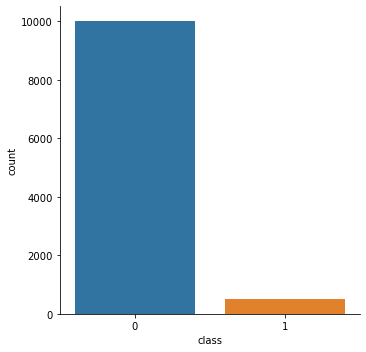

In [17]:
sns.catplot(x="class", kind="count", data=datanew)

The data is very imbalanced

### Replace empty cells with Nan for easy treatment

In [18]:
datanew = datanew.replace('', np.nan)

### Total missing values per column

[Text(0, 0, 'Attr4'),
 Text(0, 0, 'Attr5'),
 Text(0, 0, 'Attr8'),
 Text(0, 0, 'Attr9'),
 Text(0, 0, 'Attr12'),
 Text(0, 0, 'Attr13'),
 Text(0, 0, 'Attr15'),
 Text(0, 0, 'Attr16'),
 Text(0, 0, 'Attr17'),
 Text(0, 0, 'Attr19'),
 Text(0, 0, 'Attr20'),
 Text(0, 0, 'Attr21'),
 Text(0, 0, 'Attr23'),
 Text(0, 0, 'Attr24'),
 Text(0, 0, 'Attr26'),
 Text(0, 0, 'Attr27'),
 Text(0, 0, 'Attr28'),
 Text(0, 0, 'Attr30'),
 Text(0, 0, 'Attr31'),
 Text(0, 0, 'Attr32'),
 Text(0, 0, 'Attr33'),
 Text(0, 0, 'Attr34'),
 Text(0, 0, 'Attr37'),
 Text(0, 0, 'Attr39'),
 Text(0, 0, 'Attr40'),
 Text(0, 0, 'Attr41'),
 Text(0, 0, 'Attr42'),
 Text(0, 0, 'Attr43'),
 Text(0, 0, 'Attr44'),
 Text(0, 0, 'Attr45'),
 Text(0, 0, 'Attr46'),
 Text(0, 0, 'Attr47'),
 Text(0, 0, 'Attr49'),
 Text(0, 0, 'Attr50'),
 Text(0, 0, 'Attr52'),
 Text(0, 0, 'Attr53'),
 Text(0, 0, 'Attr54'),
 Text(0, 0, 'Attr56'),
 Text(0, 0, 'Attr58'),
 Text(0, 0, 'Attr60'),
 Text(0, 0, 'Attr61'),
 Text(0, 0, 'Attr62'),
 Text(0, 0, 'Attr63'),
 Text(0, 0, 'At

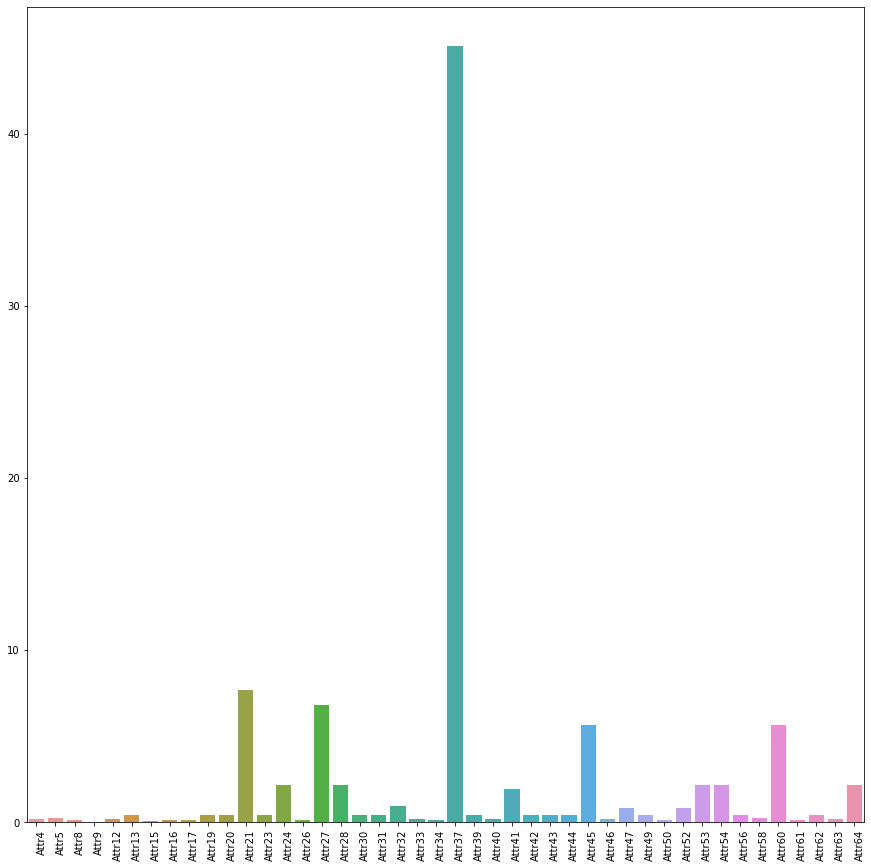

In [19]:
missingValues = datanew.columns[datanew.isna().any()].tolist()
missing_values_total = pd.DataFrame(datanew, columns=missingValues).isnull().sum()
barplt, bp_ax = plt.subplots(figsize=(15, 15))
chart = sns.barplot(x=missingValues, y=(missing_values_total*100/len(datanew.index)).round(2), ax=bp_ax)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90, horizontalalignment='left')

Attr37 has 45% missing data. So no point in keeping that column.

In [20]:
datanew.drop(columns=['Attr37'], inplace=True)

### Plotting correlation heatmap

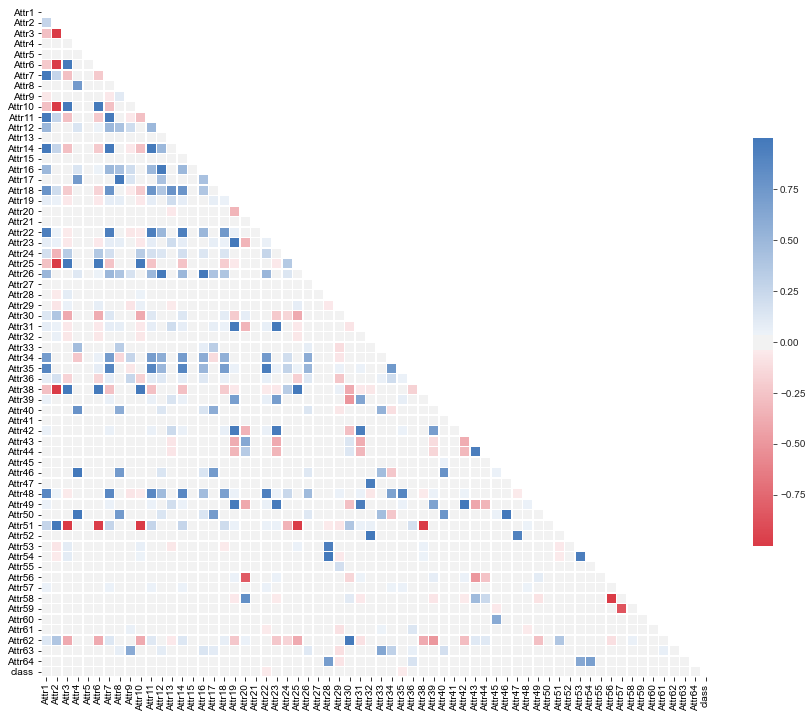

In [21]:
# visualise the data with seaborn
corr = datanew.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig1, ax1 = plt.subplots(figsize=(15, 15))
sns.set_style(style = 'white')
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, 
        square=True,
        linewidths=.5, cbar_kws={"shrink": .5}, ax=ax1)

### Checking skewness to see if there are any outliers

In [22]:
datanew.skew(axis = 0, skipna = True)

Attr1      51.971750
Attr2      71.596019
Attr3     -71.691576
Attr4     101.305786
Attr5     -96.857582
Attr6     -69.367311
Attr7      51.122493
Attr8      57.590691
Attr9      89.239152
Attr10    -71.532339
Attr11     50.325599
Attr12     63.800651
Attr13     95.399938
Attr14     51.122608
Attr15     78.016776
Attr16     66.178212
Attr17     56.863454
Attr18     49.391027
Attr19    -55.990399
Attr20     72.009401
Attr21     96.517440
Attr22     49.436071
Attr23    -56.753416
Attr24     58.740315
Attr25    -70.658843
Attr26     68.084153
Attr27     58.578751
Attr28     40.281192
Attr29     -0.030266
Attr30    -58.691195
Attr31    -56.905898
Attr32     91.096973
Attr33     49.971410
Attr34     75.075166
Attr35     52.688413
Attr36     31.606763
Attr38    -71.684939
Attr39    -52.582874
Attr40     53.749575
Attr41    101.483199
Attr42    -57.841190
Attr43     61.556419
Attr44     78.291305
Attr45     39.391541
Attr46    101.384056
Attr47     74.485814
Attr48     38.217771
Attr49    -60

#### From above we can conclude that our data is highly skewed and there must be outliers which are skewing our data

#### So the best way to impute the missing values is by imputing them with median or by mode but not by mean

# Data imputation

### Divide the data as per the class and and then do the imputation and outlier treatement

In [23]:
datazero = datanew.loc[datanew['class'] == 0]
dataone = datanew.loc[datanew['class'] == 1]

### 1. Strategy Median

#### 1.1 On all the data at once

In [24]:
imputer = SimpleImputer(strategy='median', 
                        missing_values=np.nan)
imputer = imputer.fit(datanew)
impu_df_median = pd.DataFrame(imputer.transform(datanew.loc[:,:]), 
                  columns = datanew.columns)

In [25]:
missing_columns_impu_df_median = impu_df_median.columns[impu_df_median.isna().any()].tolist()
missing_values_total_impu_df_median = pd.DataFrame(impu_df_median, columns=missing_columns_impu_df_median).isnull().sum()
missing_values_total_impu_df_median

Series([], dtype: float64)

#### 1.2 On class-seperated data

In [26]:
imputer = SimpleImputer(strategy='median', 
                        missing_values=np.nan)
imputer = imputer.fit(datazero)
impu_dzero_median = pd.DataFrame(imputer.transform(datazero.loc[:,:]), 
                  columns = datazero.columns)

In [27]:
imputer = SimpleImputer(strategy='median', 
                        missing_values=np.nan)
imputer = imputer.fit(dataone)
impu_done_median = pd.DataFrame(imputer.transform(dataone.loc[:,:]), 
                  columns = dataone.columns)

### 2. Strategy Most-Frequent or Mode

#### 2.1 On all the data at once

In [28]:
imputer = SimpleImputer(strategy='most_frequent', 
                        missing_values=np.nan)
imputer = imputer.fit(datanew)
impu_df_mode = pd.DataFrame(imputer.transform(datanew.loc[:,:]), 
                  columns = datanew.columns)

In [29]:
missing_columns_impu_df_mode = impu_df_mode.columns[impu_df_mode.isna().any()].tolist()
missing_values_total_impu_df_mode = pd.DataFrame(impu_df_mode, columns=missing_columns_impu_df_mode).isnull().sum()
missing_values_total_impu_df_mode

Series([], dtype: float64)

#### 2.2 On class-seperated data

In [30]:
imputer = SimpleImputer(strategy='most_frequent', 
                        missing_values=np.nan)
imputer = imputer.fit(datazero)
impu_dzero_mode = pd.DataFrame(imputer.transform(datazero.loc[:,:]), 
                  columns = datazero.columns)

In [31]:
imputer = SimpleImputer(strategy='most_frequent', 
                        missing_values=np.nan)
imputer = imputer.fit(dataone)
impu_done_mode = pd.DataFrame(imputer.transform(dataone.loc[:,:]), 
                  columns = dataone.columns)

### Finding out the correlation values to do variable selection

#### 1. Correlation of Non-Imputed data

In [32]:
corr_group(corr, 0.8)

Attr1   Attr1     1.000000
        Attr7     0.998670
        Attr11    0.989035
        Attr14    0.998669
        Attr22    0.942101
        Attr35    0.892008
        Attr48    0.870676
Attr2   Attr2     1.000000
        Attr3    -0.997796
        Attr6    -0.986278
        Attr10   -0.999671
        Attr25   -0.995930
        Attr38   -0.998710
        Attr51    0.998658
Attr3   Attr2    -0.997796
        Attr3     1.000000
        Attr6     0.984754
        Attr10    0.997925
        Attr25    0.994051
        Attr38    0.998415
        Attr51   -0.998782
Attr4   Attr4     1.000000
        Attr46    0.999933
        Attr50    0.998707
Attr5   Attr5     1.000000
Attr6   Attr2    -0.986278
        Attr3     0.984754
        Attr6     1.000000
        Attr10    0.985998
        Attr25    0.988859
        Attr38    0.985479
        Attr51   -0.985613
Attr7   Attr1     0.998670
        Attr7     1.000000
        Attr11    0.990676
        Attr14    0.999999
        Attr22    0.944666
 

#### 2. Correlation of Median imputed data

In [33]:
corr_group(impu_df_median.corr(), 0.8)

Attr1   Attr1     1.000000
        Attr7     0.998670
        Attr11    0.989035
        Attr14    0.998669
        Attr22    0.942101
        Attr35    0.892008
        Attr48    0.870676
Attr2   Attr2     1.000000
        Attr3    -0.997796
        Attr6    -0.986278
        Attr10   -0.999671
        Attr25   -0.995930
        Attr38   -0.998710
        Attr51    0.998658
Attr3   Attr2    -0.997796
        Attr3     1.000000
        Attr6     0.984754
        Attr10    0.997925
        Attr25    0.994051
        Attr38    0.998415
        Attr51   -0.998782
Attr4   Attr4     1.000000
        Attr46    0.999933
        Attr50    0.998706
Attr5   Attr5     1.000000
Attr6   Attr2    -0.986278
        Attr3     0.984754
        Attr6     1.000000
        Attr10    0.985998
        Attr25    0.988859
        Attr38    0.985479
        Attr51   -0.985613
Attr7   Attr1     0.998670
        Attr7     1.000000
        Attr11    0.990676
        Attr14    0.999999
        Attr22    0.944666
 

#### 3. Correlation of Mode imputed data

In [34]:
corr_group(impu_df_mode.corr(), 0.8)

Attr1   Attr1     1.000000
        Attr7     0.998670
        Attr11    0.989035
        Attr14    0.998669
        Attr22    0.942101
        Attr35    0.892008
        Attr48    0.870676
Attr2   Attr2     1.000000
        Attr3    -0.997796
        Attr6    -0.986278
        Attr10   -0.999671
        Attr25   -0.995930
        Attr38   -0.998710
        Attr51    0.998658
Attr3   Attr2    -0.997796
        Attr3     1.000000
        Attr6     0.984754
        Attr10    0.997925
        Attr25    0.994051
        Attr38    0.998415
        Attr51   -0.998782
Attr4   Attr4     1.000000
        Attr46    0.999933
        Attr50    0.998706
Attr5   Attr5     1.000000
Attr6   Attr2    -0.986278
        Attr3     0.984754
        Attr6     1.000000
        Attr10    0.985998
        Attr25    0.988859
        Attr38    0.985479
        Attr51   -0.985613
Attr7   Attr1     0.998670
        Attr7     1.000000
        Attr11    0.990676
        Attr14    0.999999
        Attr22    0.944666
 

### We can see a very high correlation almost perfect correlation between some variables in all three dataframes lets take for example group of Attr2
#### 1. Unimputed data

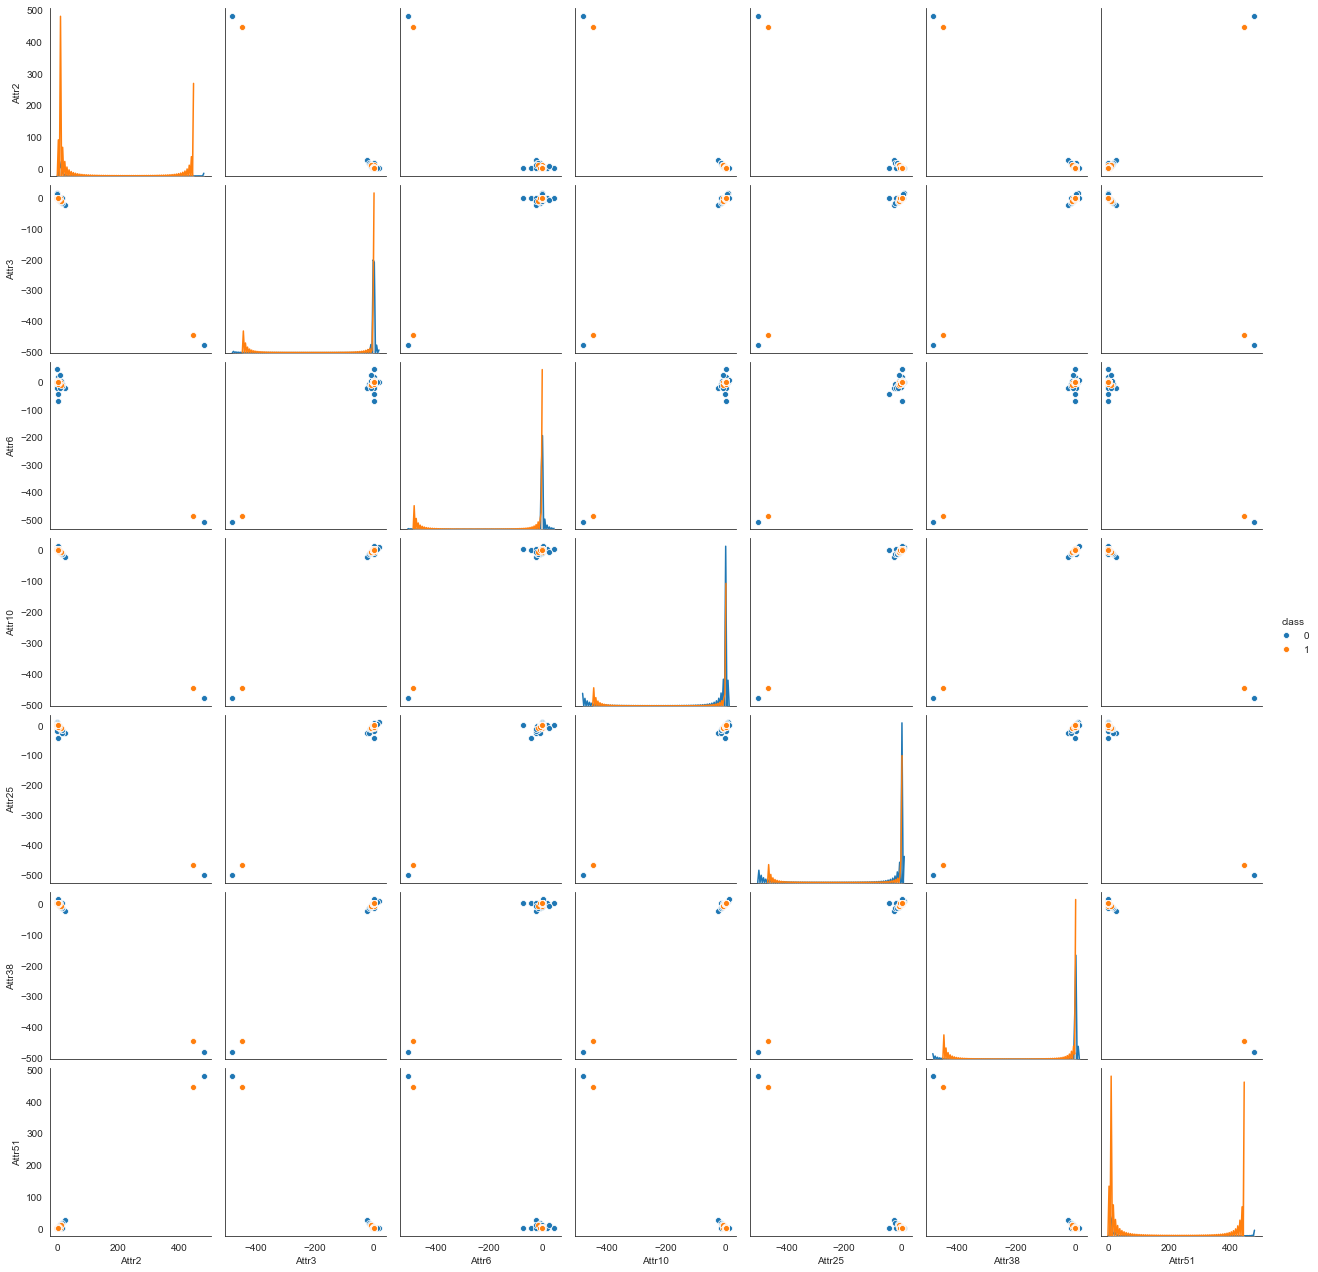

In [35]:
df_group_unimpu= datanew[['Attr2','Attr3', 'Attr6', 'Attr10', 'Attr25', 'Attr38', 'Attr51', 'class']]
sns.pairplot(df_group_unimpu, hue='class', height=2.5)

Observe correlation between Attr2 and Attr51 it is 0.998 almost perfect but in the pair plot the correlation is scattered along lot of datapoints near 0 and because of outliers it is showing false correlation so we will have to treat the outliers before selecting the features

#### 2. Median Imputed

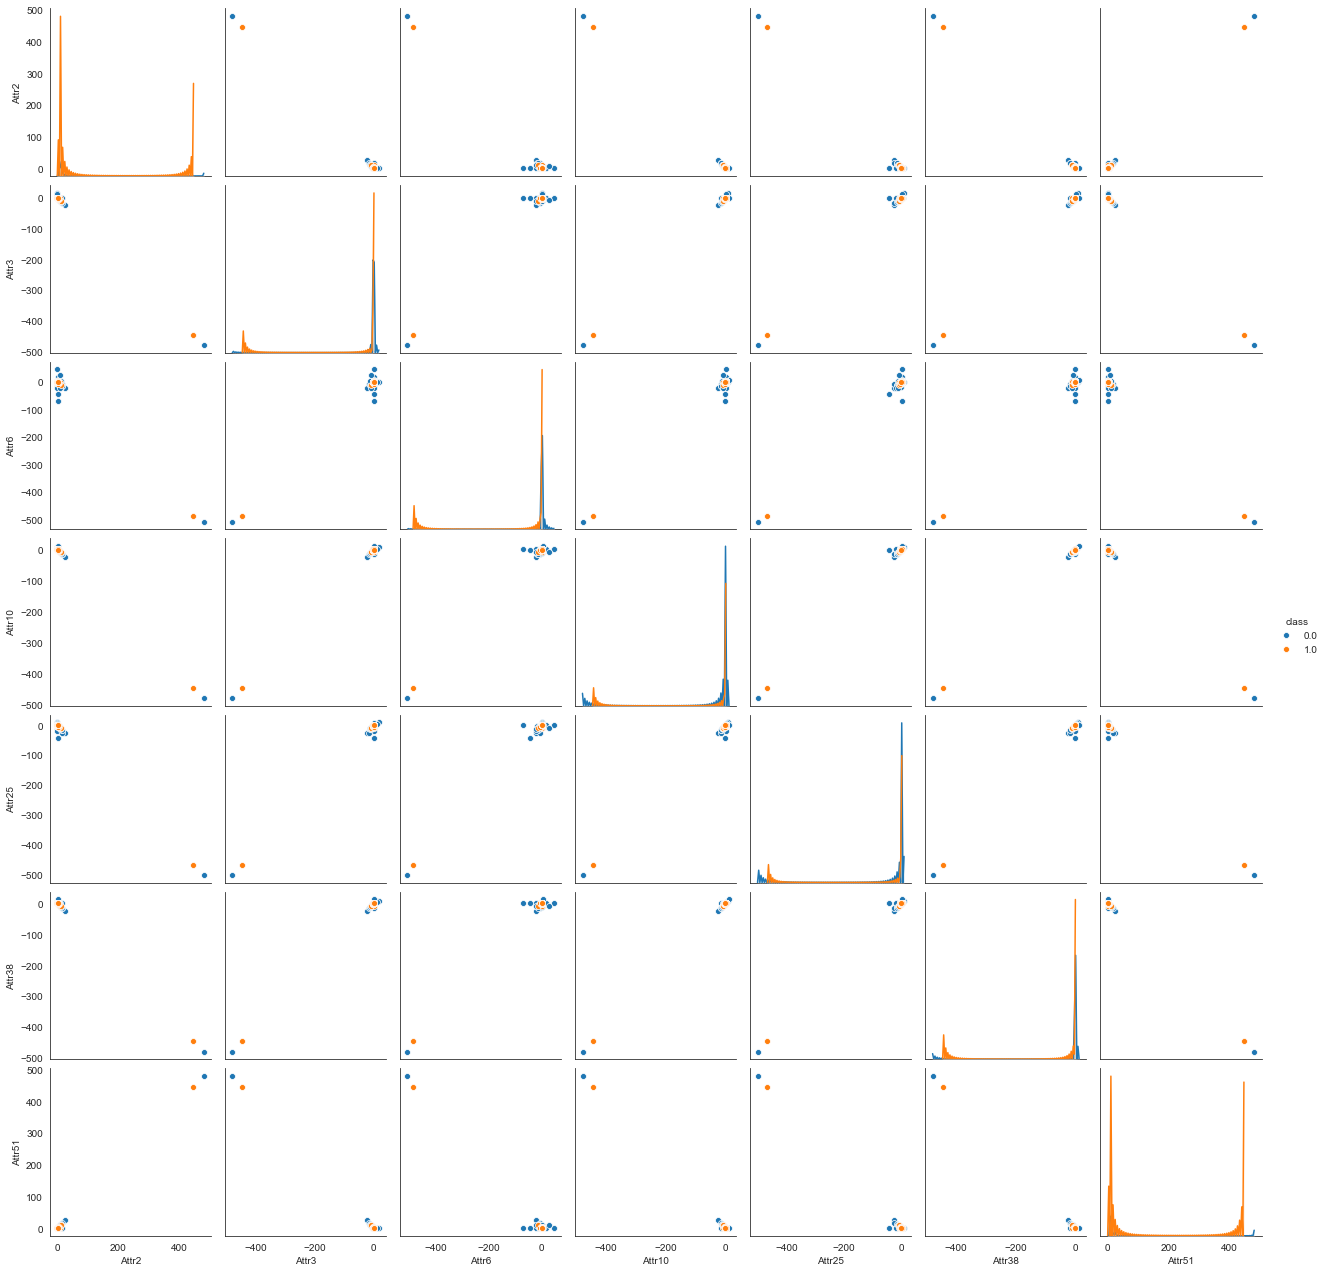

In [36]:
df_group_medianimpu= impu_df_median[['Attr2','Attr3', 'Attr6', 'Attr10', 'Attr25', 'Attr38', 'Attr51', 'class']]
sns.pairplot(df_group_medianimpu, hue='class', height=2.5)

#### 3. Mode imputed

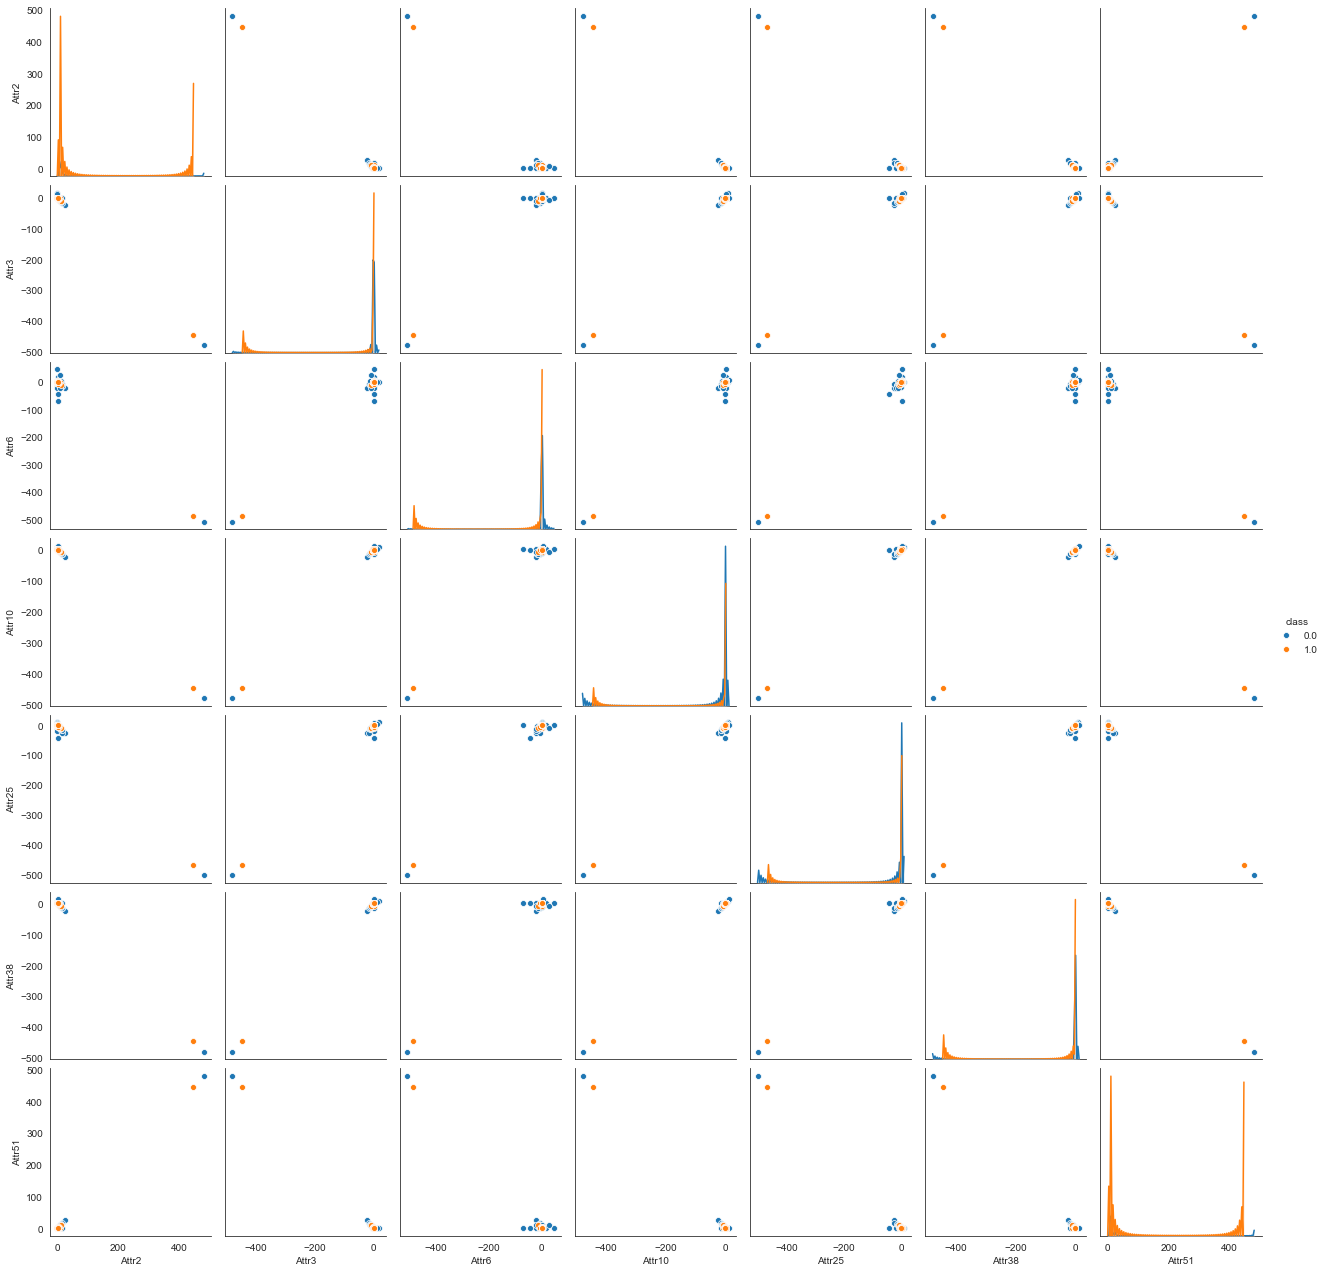

In [37]:
df_group_modeimpu= impu_df_mode[['Attr2','Attr3', 'Attr6', 'Attr10', 'Attr25', 'Attr38', 'Attr51', 'class']]
sns.pairplot(df_group_modeimpu, hue='class', height=2.5)

As suspected same observation as unimputed data, imputation has no effect on outliers

# Treating outliers by replacing them with median

### 1. Treating outliers for unimputed data

#### Detecting outliers with IQR method with tolerance of 1.5IQR

In [38]:
outlier_tolerance = 1.5
for column in datanew:
    outlier_detector(datanew[column], outlier_tolerance)

In  Attr1 	 Total outliers is 	 1266 	 out of 10503 rows. So 12.05 % outliers
In  Attr2 	 Total outliers is 	 290 	 out of 10503 rows. So 2.76 % outliers
In  Attr3 	 Total outliers is 	 271 	 out of 10503 rows. So 2.58 % outliers
In  Attr4 	 Total outliers is 	 1113 	 out of 10503 rows. So 10.6 % outliers
In  Attr5 	 Total outliers is 	 1562 	 out of 10503 rows. So 14.87 % outliers
In  Attr6 	 Total outliers is 	 3170 	 out of 10503 rows. So 30.18 % outliers
In  Attr7 	 Total outliers is 	 1139 	 out of 10503 rows. So 10.84 % outliers
In  Attr8 	 Total outliers is 	 1146 	 out of 10503 rows. So 10.91 % outliers
In  Attr9 	 Total outliers is 	 726 	 out of 10503 rows. So 6.91 % outliers
In  Attr10 	 Total outliers is 	 305 	 out of 10503 rows. So 2.9 % outliers
In  Attr11 	 Total outliers is 	 1012 	 out of 10503 rows. So 9.64 % outliers
In  Attr12 	 Total outliers is 	 1516 	 out of 10503 rows. So 14.43 % outliers
In  Attr13 	 Total outliers is 	 1100 	 out of 10503 rows. So 10.47 % ou

#### Here most of the columns have high amount of outliers so we cannot delete those rows hence we are treating them with medians 

In [39]:
df_median_ol_treatment = datanew.copy(deep=True)

In [40]:
df_median_ol_treatment.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,10503.000000,10503.000000,10503.000000,10485.000000,1.047800e+04,10503.000000,10503.000000,10489.000000,10500.000000,10503.000000,10503.000000,10485.000000,10460.000000,10503.000000,1.049500e+04,10489.000000,10489.000000,10503.000000,10460.000000,10460.000000,9696.000000,10503.000000,10460.000000,10276.000000,10503.000000,10489.000000,9.788000e+03,10275.000000,10503.000000,10460.000000,10460.000000,1.040200e+04,10485.000000,10489.000000,10503.000000,10503.000000,10503.000000,10460.000000,10485.000000,10301.000000,10460.000000,10460.000000,10460.000000,9912.000000,10485.000000,1.041700e+04,10503.000000,10460.000000,10489.000000,10503.000000,10417.000000,10275.000000,10275.000000,1.050300e+04,10460.000000,10503.000000,10474.000000,10503.000000,9.911000e+03,10486.000000,1.046000e+04,10485.000000,10275.000000,10503.000000
mean,0.052844,0.619911,0.095490,9.980499,-1.347662e+03,-0.121159,0.065624,19.140113,1.819254,0.366093,0.086764,2.411266,0.376563,0.065634,3.004332e+03,2.729654,20.511539,0.070739,-0.170778,68.448531,4.670725,0.075676,-0.176466,0.211936,0.196153,2.580730,1.185945e+03,6.092884,3.921179,0.459346,-0.177084,1.171670e+03,8.419887,5.398356,0.071075,1.981250,0.465510,-0.076355,2.381026,28.707178,-0.141671,195.389286,126.940260,17.451297,8.978029,5.424888e+02,0.004834,-0.217844,8.686024,0.497135,11.244158,5.725829,6.708568,6.638549e+03,-0.530082,-0.014817,3.848794,1.429319,5.713363e+02,13.935361,1.355370e+02,9.095149,35.766800,0.047129
std,0.647797,6.427041,6.420056,523.691951,1.185806e+05,6.970625,0.651152,717.756745,7.581659,6.428603,0.655407,111.459642,49.675550,0.651151,1.091981e+05,110.233475,721.812766,0.835328,11.210201,1083.699904,305.897238,0.581734,11.149274,2.093845,6.742161,108.823993,3.469123e+04,94.713753,0.840528,71.755042,11.157003,6.841270e+04,37.696764,69.035263,0.572124,2.630705,6.425362,8.079334,37.819839,2845.290346,10.787555,3303.309554,2766.505503,1720.342176,523.565601,3.126416e+04,0.629770,11.910935,522.528325,6.420885,851.867915,89.708042,93.511530,5.989196e+04,55.978608,18.684047,190.201224,77.273270,3.715967e+04,83.704103,2.599116e+04,31.419096,428.298315,0.211926
min,-17.692000,0.000000,-479.730000,0.002080,-1.190300e+07,-508.120000,-17.692000,-2.081800,-1.215700,-479.730000,-17.692000,-1543.800000,-631.710000,-17.692000,-2.321800e+06,-204.300000,-0.043411,-17.692000,-771.650000,-0.001439,-1.107500,-17.692000,-771.650000,-60.742000,-500.750000,-204.300000,-1.901300e+05,-690.400000,-0.358530,-6351.700000,-771.390000,-9.295600e+03,-1.921900,-1696.000000,-17.073000,-0.000084,-479.730000,-551.110000,-7.081900,-667.730000,-765.800000,-25113.000000,-25113.000000,-74385.000000,-6.469200,-1.730300e+01,-17.692000,-905.750000,0.002080,0.000000,-25.467000,-869.040000,-706.490000,-7.513800e+05,-5691.700000,-1667.300000,-198.690000,-172.070000,0.000000e+00,-6.590300,-2.336500e+06,-0.000156,-0.000102,0.000000
25%,0.000686,0.253955,0.017461,1.040100,-5.207075e+01,0.000000,0.002118,0.431270,1.011275,0.297340,0.009809,0.006183,0.020740,0.002131,1.865950e+02,0.060302,1.449200,0.002131,0.001648,14.253750,0.796673,0.000000,0.000556,0.014938,0.135695,0.055067,0.000000e+00,0.027178,3.393200,0.073850,0.004012,4.471900e+01,2.785900,0.367460,0.001730,1.043500,0.426810,0.001557,0.053666,0.022026,0.000000,65.627250,34.214750,0.006157,0.602830,1.494100e+01,-0.048988,-0.036186,0.749370,0.177200,0.122470,0.667285,0.950435,1.462100e+01,0.005137,0.006796,0.875560,0.000000,5.533150e+00,4.486075,4.073700e+01,3.062800,2.023350,0.000000
50%,0.043034,0.464140,0.198560,1.605600,1.579300e+00,0.0

In [41]:
# Iterating through every column and treating the outliers one column at a time
for column in df_median_ol_treatment:
    outlier_treater_median(df_median_ol_treatment[column], outlier_tolerance, df_median_ol_treatment)

In [42]:
df_median_ol_treatment.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,10503.000000,10503.000000,10503.000000,10485.000000,10478.000000,10503.000000,10503.000000,10489.000000,10500.000000,10503.000000,10503.000000,10485.000000,10460.000000,10503.000000,10495.000000,10489.000000,10489.000000,10503.000000,10460.000000,10460.000000,9696.000000,10503.000000,10460.000000,10276.000000,10503.000000,10489.000000,9788.000000,10275.000000,10503.000000,10460.000000,10460.000000,10402.000000,10485.000000,10489.000000,10503.000000,10503.000000,10503.000000,10460.000000,10485.000000,10301.000000,10460.000000,10460.000000,10460.000000,9912.000000,10485.000000,10417.000000,10503.000000,10460.000000,10489.000000,10503.000000,10417.000000,10275.000000,10275.000000,10503.000000,10460.000000,10503.000000,10474.000000,10503.000000,9911.000000,10486.000000,10460.000000,10485.000000,10275.000000,10503.000000
mean,0.055132,0.471526,0.226989,1.797780,2.052617,0.008607,0.064839,1.379031,1.416955,0.512450,0.079971,0.201046,0.074509,0.064850,983.256606,0.278934,2.426973,0.064848,0.041018,38.388497,0.944285,0.068338,0.035532,0.185714,0.384008,0.252794,1.380672,0.574669,3.922662,0.230334,0.048461,83.343497,5.106519,2.499953,0.067020,1.673840,0.606513,0.043871,0.304956,0.093779,0.044558,101.126796,56.178645,0.331790,1.182433,41.497228,0.023854,0.014484,1.366370,0.355045,0.227819,1.281415,1.473313,1401.824380,0.060645,0.125739,0.943527,0.066428,11.426956,7.003060,76.024286,5.592025,4.759630,0.047129
std,0.087436,0.270816,0.287738,1.140869,70.153633,0.040741,0.100878,1.401404,0.712702,0.268852,0.107252,0.366147,0.077457,0.100873,1293.723823,0.368354,1.436500,0.100874,0.059989,30.815519,0.221717,0.101049,0.052322,0.252807,0.305054,0.335255,2.542282,0.884818,0.778408,0.232568,0.066150,52.247536,3.271502,2.570040,0.101575,0.887692,0.232288,0.062112,0.376925,0.106460,0.062394,50.268383,30.712851,0.593879,0.844468,33.968359,0.105885,0.066650,0.915897,0.225436,0.142702,0.935266,0.856059,2559.090079,0.085951,0.175138,0.082599,0.132909,8.651786,3.713534,47.596773,3.551275,4.099627,0.211926
min,-0.183050,0.000000,-0.583670,0.002080,-213.940000,-0.108380,-0.207790,-2.081800,-0.000084,-0.344980,-0.216090,-0.838260,-0.148340,-0.207790,-2801.200000,-0.813470,-0.043411,-0.207790,-0.126850,-0.001439,0.333360,-0.218350,-0.111910,-0.522850,-0.577780,-0.744590,-7.206000,-2.254000,1.816400,-0.454490,-0.138510,-0.002254,-1.921900,-5.502500,-0.213670,-0.000084,-0.115510,-0.132440,-0.411990,-0.235740,-0.136930,-0.293730,0.000000,-1.406200,-0.079512,-17.303000,-0.273230,-0.179900,0.002080,0.000000,0.000000,-1.724500,-1.277400,-6486.200000,-0.181850,-0.389200,0.695110,-0.351810,0.000000,-0.014534,0.000000,-0.000156,-0.000102,0.000000
25%,0.008169,0.253955,0.038011,1.040100,-32.013250,0.000000,0.010157,0.431270,1.011375,0.322885,0.020209,0.019522,0.029677,0.010171,326.485000,0.070764,1.449200,0.010171,0.009075,14.253750,0.808110,0.000285,0.007697,0.031615,0.175565,0.065539,0.185785,0.056073,3.410800,0.083047,0.013559,44.725750,2.785900,0.374370,0.009312,1.043500,0.457290,0.008460,0.053764,0.034685,0.004648,65.649500,34.228750,0.043479,0.603040,14.941000,-0.028060,-0.014639,0.749370,0.177200,0.122530,0.715535,0.983205,100.370000,0.014210,0.027493,0.904880,0.000000,5.533150,4.487600,40.781750,3.062800,2.023350,0.000000
50%,0.043034,0.464140,0.198560,1.605600,1.579300,0.000000,0.050945,1.111000,1.199000,0.515500,0.068104,0.155880,0.066433,0.050953,805.690000,0.235140,2.152500,0.050953,0.032117,34.430750,0.955035,0.054633,0.027129,0.158370,0.377690,0.213260,1.066900,0.459930,3.932100,0.216525,0.039689,77.522000,4.680900,

#### Looks like the outliers are gone lets see the skewness of the data

In [43]:
df_median_ol_treatment.skew(axis = 0, skipna = True)

Attr1     0.292951
Attr2     0.395105
Attr3     0.083997
Attr4     1.372885
Attr5     0.060333
Attr6     1.932415
Attr7     0.284860
Attr8     1.495469
Attr9     1.034915
Attr10   -0.337776
Attr11    0.262639
Attr12    0.766119
Attr13    0.309812
Attr14    0.284659
Attr15    0.538153
Attr16    0.934837
Attr17    1.491486
Attr18    0.284722
Attr19    0.294779
Attr20    0.975859
Attr21    0.045587
Attr22    0.378081
Attr23    0.353005
Attr24    0.353357
Attr25   -0.330302
Attr26    0.895022
Attr27    1.315336
Attr28    1.197481
Attr29   -0.020777
Attr30    0.527366
Attr31    0.287743
Attr32    0.995194
Attr33    1.042976
Attr34    1.245447
Attr35    0.323601
Attr36    0.700900
Attr38   -0.586464
Attr39    0.332009
Attr40    1.903489
Attr41    0.673454
Attr42    0.363385
Attr43    0.600822
Attr44    0.639471
Attr45    0.677037
Attr46    1.386378
Attr47    1.018310
Attr48    0.215258
Attr49    0.090773
Attr50    1.359236
Attr51    0.687110
Attr52    0.993238
Attr53    0.978898
Attr54    1.

#### The skewness is also reduced significantly lets now see the correlation

In [44]:
median_treated_corr = df_median_ol_treatment.corr()
corr_group(median_treated_corr, 0.8)

Attr1   Attr1     1.000000
        Attr7     0.914111
        Attr11    0.850580
        Attr14    0.914053
        Attr18    0.914074
Attr2   Attr2     1.000000
        Attr10   -0.979433
Attr3   Attr3     1.000000
Attr4   Attr4     1.000000
Attr5   Attr5     1.000000
Attr6   Attr6     1.000000
Attr7   Attr1     0.914111
        Attr7     1.000000
        Attr11    0.898072
        Attr14    0.999949
        Attr18    0.999968
        Attr22    0.819075
Attr8   Attr8     1.000000
        Attr17    0.964775
Attr9   Attr9     1.000000
Attr10  Attr2    -0.979433
        Attr10    1.000000
Attr11  Attr1     0.850580
        Attr7     0.898072
        Attr11    1.000000
        Attr14    0.898008
        Attr18    0.898029
        Attr22    0.843273
Attr12  Attr12    1.000000
Attr13  Attr13    1.000000
Attr14  Attr1     0.914053
        Attr7     0.999949
        Attr11    0.898008
        Attr14    1.000000
        Attr18    0.999998
        Attr22    0.819027
Attr15  Attr15    1.000000
A

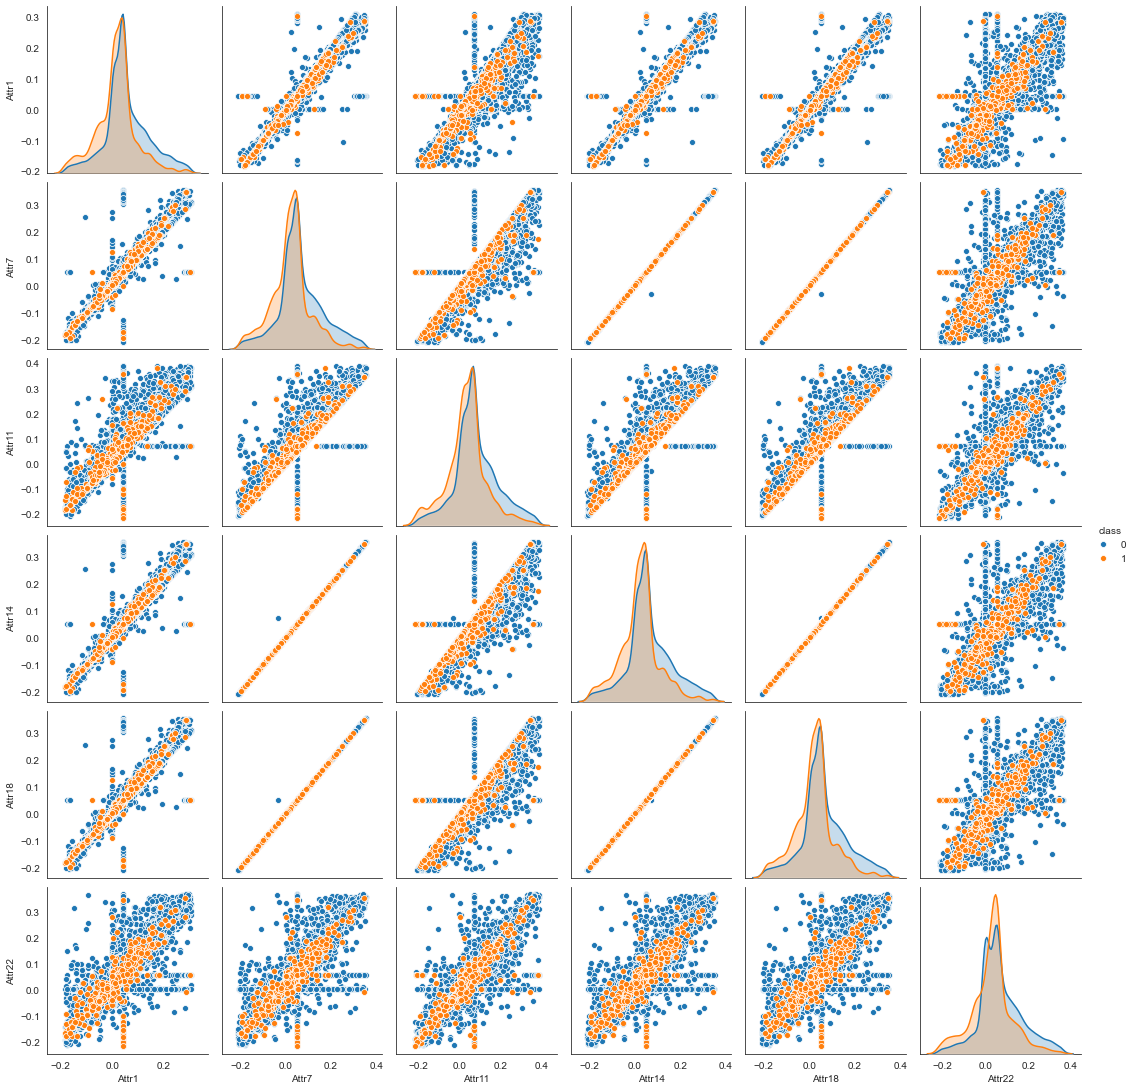

In [45]:
df_attr7 = df_median_ol_treatment[['Attr1', 'Attr7', 'Attr11', 'Attr14','Attr18','Attr22', 'class']]
sns.pairplot(df_attr7, hue='class', height=2.5)

### 2. Treating outliers for Median imputed data

#### Detecting outliers with IQR method with tolerance of 1.5IQR

#### 1. All data at once

In [46]:
for column in impu_df_median:
    outlier_detector(impu_df_median[column], outlier_tolerance)

In  Attr1 	 Total outliers is 	 1266 	 out of 10503 rows. So 12.05 % outliers
In  Attr2 	 Total outliers is 	 290 	 out of 10503 rows. So 2.76 % outliers
In  Attr3 	 Total outliers is 	 271 	 out of 10503 rows. So 2.58 % outliers
In  Attr4 	 Total outliers is 	 1118 	 out of 10503 rows. So 10.64 % outliers
In  Attr5 	 Total outliers is 	 1567 	 out of 10503 rows. So 14.92 % outliers
In  Attr6 	 Total outliers is 	 3170 	 out of 10503 rows. So 30.18 % outliers
In  Attr7 	 Total outliers is 	 1139 	 out of 10503 rows. So 10.84 % outliers
In  Attr8 	 Total outliers is 	 1150 	 out of 10503 rows. So 10.95 % outliers
In  Attr9 	 Total outliers is 	 726 	 out of 10503 rows. So 6.91 % outliers
In  Attr10 	 Total outliers is 	 305 	 out of 10503 rows. So 2.9 % outliers
In  Attr11 	 Total outliers is 	 1012 	 out of 10503 rows. So 9.64 % outliers
In  Attr12 	 Total outliers is 	 1526 	 out of 10503 rows. So 14.53 % outliers
In  Attr13 	 Total outliers is 	 1115 	 out of 10503 rows. So 10.62 % o

In [47]:
df_medimp_median_ol_treatment = impu_df_median.copy(deep=True)

In [48]:
df_medimp_median_ol_treatment.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,10503.000000,10503.000000,10503.000000,10503.000000,1.050300e+04,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,1.050300e+04,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,1.050300e+04,10503.000000,10503.000000,10503.000000,10503.000000,1.050300e+04,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,1.050300e+04,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,1.050300e+04,10503.000000,10503.000000,10503.000000,10503.000000,1.050300e+04,10503.000000,1.050300e+04,10503.000000,10503.000000,10503.000000
mean,0.052844,0.619911,0.095490,9.966146,-1.344451e+03,-0.121159,0.065624,19.116081,1.819077,0.366093,0.086764,2.407401,0.375293,0.065634,3.002658e+03,2.726329,20.487068,0.070739,-0.169947,68.309267,4.385229,0.075676,-0.175632,0.210779,0.196153,2.577575,1.105284e+03,5.970604,3.921179,0.458352,-0.176197,1.161148e+03,8.413479,5.393895,0.071075,1.981250,0.465510,-0.075903,2.377281,28.156586,-0.140949,194.995198,126.643365,16.484020,8.964460,5.383507e+02,0.004834,-0.216928,8.676088,0.497135,11.153825,5.627621,6.592754,6.638549e+03,-0.527700,-0.014817,3.840799,1.429319,5.396940e+02,13.923613,1.352714e+02,9.088370,35.078491,0.047129
std,0.647797,6.427041,6.420056,523.243080,1.184394e+05,6.970625,0.651152,717.278474,7.580583,6.428603,0.655407,111.364122,49.573752,0.651151,1.091565e+05,110.160013,721.331800,0.835328,11.187235,1081.481228,293.911052,0.581734,11.126433,2.071107,6.742161,108.751468,3.349082e+04,93.683584,0.840528,71.607994,11.134148,6.808302e+04,37.664763,68.989341,0.572124,2.630705,6.425362,8.062780,37.787522,2817.796456,10.765453,3296.545716,2760.839907,1671.239870,523.116826,3.113592e+04,0.629770,11.886534,522.179994,6.420885,848.373390,88.731360,92.494153,5.989196e+04,55.863902,18.684047,189.938495,77.273270,3.609736e+04,83.636837,2.593790e+04,31.392586,423.648795,0.211926
min,-17.692000,0.000000,-479.730000,0.002080,-1.190300e+07,-508.120000,-17.692000,-2.081800,-1.215700,-479.730000,-17.692000,-1543.800000,-631.710000,-17.692000,-2.321800e+06,-204.300000,-0.043411,-17.692000,-771.650000,-0.001439,-1.107500,-17.692000,-771.650000,-60.742000,-500.750000,-204.300000,-1.901300e+05,-690.400000,-0.358530,-6351.700000,-771.390000,-9.295600e+03,-1.921900,-1696.000000,-17.073000,-0.000084,-479.730000,-551.110000,-7.081900,-667.730000,-765.800000,-25113.000000,-25113.000000,-74385.000000,-6.469200,-1.730300e+01,-17.692000,-905.750000,0.002080,0.000000,-25.467000,-869.040000,-706.490000,-7.513800e+05,-5691.700000,-1667.300000,-198.690000,-172.070000,0.000000e+00,-6.590300,-2.336500e+06,-0.000156,-0.000102,0.000000
25%,0.000686,0.253955,0.017461,1.040900,-5.196150e+01,0.000000,0.002118,0.431935,1.011350,0.297340,0.009809,0.006372,0.020928,0.002131,1.867450e+02,0.060550,1.450350,0.002131,0.001742,14.400500,0.813550,0.000000,0.000639,0.017663,0.135695,0.055322,1.449050e-02,0.035968,3.393200,0.074598,0.004132,4.511250e+01,2.789700,0.370620,0.001730,1.043500,0.426810,0.001677,0.053836,0.022861,0.000000,65.740000,34.298000,0.014509,0.603495,1.514850e+01,-0.048988,-0.035852,0.749810,0.177200,0.123250,0.680975,0.958225,1.462100e+01,0.005336,0.006796,0.875700,0.000000,5.734300e+00,4.490600,4.092850e+01,3.064050,2.055600,0.000000
50%,0.043034,0.464140,0.198560,1.605600,1.579300e+00,0

In [49]:
# Iterating through every column and treating the outliers one column at a time
for column in df_medimp_median_ol_treatment:
    outlier_treater_median(df_medimp_median_ol_treatment[column], outlier_tolerance, df_medimp_median_ol_treatment)

In [50]:
df_medimp_median_ol_treatment.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000
mean,0.055132,0.471526,0.226989,1.795439,2.030768,0.008607,0.064839,1.376627,1.416892,0.512450,0.079971,0.199986,0.074311,0.064850,982.287030,0.278732,2.426086,0.064848,0.040955,38.293804,0.944445,0.068338,0.035436,0.183725,0.384008,0.252721,1.267725,0.559830,3.922662,0.230125,0.048424,83.051109,5.104709,2.498470,0.067020,1.673840,0.606513,0.043806,0.304019,0.092644,0.044498,101.015064,56.107391,0.318579,1.181030,41.363046,0.023854,0.014328,1.365541,0.355045,0.227182,1.270319,1.462983,1401.824380,0.060543,0.125739,0.943560,0.066428,11.016224,7.000049,75.940138,5.590064,4.702908,0.047129
std,0.087436,0.270816,0.287738,1.136522,69.911659,0.040741,0.100878,1.396961,0.712609,0.268852,0.107252,0.363974,0.076826,0.100873,1291.940342,0.367562,1.434679,0.100874,0.059658,30.631585,0.199486,0.101049,0.052131,0.246684,0.305054,0.334711,2.161316,0.849322,0.778408,0.231472,0.065578,51.619883,3.267011,2.566927,0.101575,0.887692,0.232288,0.061816,0.375273,0.103272,0.062193,50.008876,30.553091,0.538778,0.841708,33.677095,0.105885,0.065944,0.914187,0.225436,0.141312,0.902753,0.825016,2559.090079,0.085358,0.175138,0.082353,0.132909,7.804536,3.706398,47.400359,3.546351,3.976323,0.211926
min,-0.183050,0.000000,-0.583670,0.002080,-213.500000,-0.108380,-0.207790,-2.081800,-0.000084,-0.344980,-0.216090,-0.833330,-0.146520,-0.207790,-2801.200000,-0.808800,-0.043411,-0.207790,-0.126450,-0.001439,0.401060,-0.218350,-0.111910,-0.506570,-0.577780,-0.742820,-6.171600,-2.157100,1.816400,-0.450680,-0.137250,-0.002254,-1.921900,-5.502500,-0.213670,-0.000084,-0.115510,-0.131500,-0.411990,-0.229260,-0.136480,-0.293730,0.000000,-1.278100,-0.079512,-17.303000,-0.273230,-0.178470,0.002080,0.000000,0.000000,-1.631300,-1.182200,-6486.200000,-0.180910,-0.389200,0.695810,-0.351810,0.000000,-0.014534,0.000000,-0.000156,-0.000102,0.000000
25%,0.008169,0.253955,0.038011,1.040900,-31.855500,0.000000,0.010157,0.431935,1.011450,0.322885,0.020209,0.019749,0.030052,0.010171,326.960000,0.070946,1.450350,0.010171,0.009177,14.400500,0.830650,0.000285,0.007810,0.034574,0.175565,0.065608,0.270860,0.065863,3.410800,0.083637,0.013770,45.139500,2.789700,0.375165,0.009312,1.043500,0.457290,0.008617,0.053887,0.035830,0.004832,65.809500,34.307000,0.059534,0.603945,15.148500,-0.028060,-0.014228,0.749810,0.177200,0.123415,0.727015,0.993640,100.370000,0.014462,0.027493,0.905200,0.000000,5.734300,4.491000,40.938500,3.064050,2.055600,0.000000
50%,0.043034,0.464140,0.198560,1.605600,1.579300,0.000000,0.050945,1.111000,1.199000,0.515500,0.068104,0.155880,0.066433,0.050953,805.690000,0.235140,2.152500,0.050953,0.032117,34.432500,0.955035,0.054633,0.027129,0.158370,0.377690,0.213260,1.066900,0.459930,3.932100,0.216525,0.039689,77.522000,4.680

In [51]:
df_medimp_median_ol_treatment.skew(axis = 0, skipna = True)

Attr1     0.292951
Attr2     0.395105
Attr3     0.083997
Attr4     1.371207
Attr5     0.058973
Attr6     1.932415
Attr7     0.284860
Attr8     1.494315
Attr9     1.035275
Attr10   -0.337776
Attr11    0.262639
Attr12    0.757914
Attr13    0.305940
Attr14    0.284659
Attr15    0.535660
Attr16    0.936530
Attr17    1.492465
Attr18    0.284722
Attr19    0.298158
Attr20    0.972941
Attr21    0.008705
Attr22    0.378081
Attr23    0.351243
Attr24    0.350866
Attr25   -0.330302
Attr26    0.897656
Attr27    1.238813
Attr28    1.170706
Attr29   -0.020777
Attr30    0.528741
Attr31    0.296284
Attr32    0.990065
Attr33    1.043594
Attr34    1.246130
Attr35    0.323601
Attr36    0.700900
Attr38   -0.586464
Attr39    0.335684
Attr40    1.904445
Attr41    0.660672
Attr42    0.365772
Attr43    0.595191
Attr44    0.634251
Attr45    0.682215
Attr46    1.385161
Attr47    1.018290
Attr48    0.215258
Attr49    0.088697
Attr50    1.359035
Attr51    0.687110
Attr52    0.989765
Attr53    0.960386
Attr54    1.

#### 2.1 Zero-class isolated data

In [52]:
for column in impu_dzero_median:
    outlier_detector(impu_dzero_median[column], outlier_tolerance)

In  Attr1 	 Total outliers is 	 1148 	 out of 10008 rows. So 11.47 % outliers
In  Attr2 	 Total outliers is 	 267 	 out of 10008 rows. So 2.67 % outliers
In  Attr3 	 Total outliers is 	 239 	 out of 10008 rows. So 2.39 % outliers
In  Attr4 	 Total outliers is 	 1059 	 out of 10008 rows. So 10.58 % outliers
In  Attr5 	 Total outliers is 	 1508 	 out of 10008 rows. So 15.07 % outliers
In  Attr6 	 Total outliers is 	 2787 	 out of 10008 rows. So 27.85 % outliers
In  Attr7 	 Total outliers is 	 1023 	 out of 10008 rows. So 10.22 % outliers
In  Attr8 	 Total outliers is 	 1085 	 out of 10008 rows. So 10.84 % outliers
In  Attr9 	 Total outliers is 	 691 	 out of 10008 rows. So 6.9 % outliers
In  Attr10 	 Total outliers is 	 278 	 out of 10008 rows. So 2.78 % outliers
In  Attr11 	 Total outliers is 	 924 	 out of 10008 rows. So 9.23 % outliers
In  Attr12 	 Total outliers is 	 1416 	 out of 10008 rows. So 14.15 % outliers
In  Attr13 	 Total outliers is 	 1003 	 out of 10008 rows. So 10.02 % ou

In [53]:
dzero_median_ol_treatment = impu_dzero_median.copy(deep=True)

In [54]:
dzero_median_ol_treatment.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,10008.000000,10008.000000,10008.000000,10008.000000,1.000800e+04,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,1.000800e+04,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,1.000800e+04,10008.000000,10008.000000,10008.000000,10008.000000,1.000800e+04,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,1.000800e+04,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,1.000800e+04,10008.000000,10008.000000,10008.000000,10008.000000,1.000800e+04,10008.000000,1.000800e+04,10008.000000,10008.000000,10008.0
mean,0.056747,0.569086,0.144450,10.207129,-1.406993e+03,-0.069879,0.069754,19.867138,1.821278,0.417198,0.090693,2.684037,0.391075,0.069765,2.893466e+03,2.855246,21.253611,0.075122,-0.178823,68.700984,4.551157,0.080896,-0.184592,0.226419,0.251475,2.701403,1.153214e+03,6.059361,3.926993,0.329723,-0.186154,1.166420e+03,8.225202,5.445392,0.076758,1.969415,0.516020,-0.074788,2.354073,29.546344,-0.145515,196.630058,127.888096,17.307103,9.234239,5.614034e+02,0.008384,-0.222950,8.929521,0.448377,11.673721,5.715410,6.710377,6.893994e+03,-0.550661,0.023908,3.978946,1.436746,5.641191e+02,14.024573,9.478125e+01,9.103736,35.144879,0.0
std,0.620799,4.839168,4.832888,535.919660,1.213330e+05,5.224381,0.624289,734.736127,7.753055,4.841621,0.630154,113.027997,50.782889,0.624288,1.106243e+05,112.847048,738.888534,0.822805,11.451258,1107.767690,301.091508,0.581559,11.388921,2.080906,5.090586,111.404745,3.429900e+04,95.614345,0.840649,72.677223,11.396908,6.963995e+04,26.536864,70.589021,0.581996,2.580355,4.836367,8.259051,37.900118,2886.639760,11.027440,3374.659343,2825.438033,1712.066679,535.838524,3.189642e+04,0.631971,12.175614,534.858710,4.830539,869.099162,90.714444,94.575170,6.113927e+04,57.228520,18.972780,194.578375,79.056957,3.697915e+04,85.607374,2.632723e+04,29.431665,431.827838,0.0
min,-17.692000,0.000000,-479.730000,0.002080,-1.190300e+07,-508.120000,-17.692000,-2.081800,-1.215700,-479.730000,-17.692000,-274.570000,-631.710000,-17.692000,-2.321800e+06,-204.300000,-0.043411,-17.692000,-771.650000,-0.001439,-1.107500,-17.692000,-771.650000,-60.742000,-500.750000,-204.300000,-1.901300e+05,-690.400000,-0.358530,-6351.700000,-771.390000,-9.295600e+03,-1.921900,-1696.000000,-17.073000,-0.000084,-479.730000,-551.110000,-7.081900,-667.730000,-765.800000,-25113.000000,-25113.000000,-74385.000000,-6.469200,-1.730300e+01,-17.692000,-905.750000,0.002080,0.000000,-25.467000,-869.040000,-706.490000,-7.513800e+05,-5691.700000,-1667.300000,-198.690000,-172.070000,0.000000e+00,-6.590300,-2.336500e+06,-0.000156,-0.000102,0.0
25%,0.001688,0.248762,0.024004,1.060550,-4.922325e+01,0.000000,0.003665,0.454275,1.013500,0.307395,0.011792,0.009730,0.023151,0.003673,2.003575e+02,0.069621,1.475350,0.003673,0.002727,14.422750,0.811785,0.000000,0.001300,0.026311,0.146792,0.063632,1.975250e-02,0.049828,3.395700,0.071496,0.005242,4.441500e+01,2.831500,0.379385,0.003167,1.043500,0.441077,0.002671,0.056929,0.023979,0.000000,65.833000,34.562750,0.021387,0.624872,1.527050e+01,-0.046966,-0.033912,0.763075,0.174083,0.121608,0.702275,0.975982,3.325325e+01,0.007105,0.008476,0.874302,0.000000,5.783875e+00,4.492125,4.030200e+01,3.125700,2.057200,0.0
50%,0.045404,0.455845,0.205955,1.645900,3.284400e+00,0.000000,0.054174,1.148700,

In [55]:
# Iterating through every column and treating the outliers one column at a time
for column in dzero_median_ol_treatment:
    outlier_treater_median(dzero_median_ol_treatment[column], outlier_tolerance, dzero_median_ol_treatment)

In [56]:
dzero_median_ol_treatment.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.0
mean,0.057590,0.463682,0.232689,1.835526,3.860345,0.011295,0.067706,1.430977,1.418498,0.520048,0.082835,0.214048,0.077359,0.067722,980.160485,0.296044,2.473142,0.067720,0.043017,37.950157,0.944664,0.071017,0.037007,0.193861,0.392939,0.268142,1.325649,0.579158,3.927433,0.224848,0.050239,81.848991,5.171447,2.533522,0.069908,1.667770,0.614216,0.045726,0.318195,0.091938,0.046209,100.765101,56.215600,0.340259,1.216141,41.195764,0.025680,0.015496,1.397189,0.348310,0.224203,1.290667,1.482984,1486.499091,0.062354,0.128492,0.942192,0.065549,11.096716,6.981282,74.641869,5.695057,4.710805,0.0
std,0.088468,0.267637,0.286449,1.161172,69.807082,0.048705,0.102209,1.436126,0.708415,0.266194,0.107798,0.375275,0.077968,0.102203,1243.715344,0.377911,1.460331,0.102203,0.060681,30.175845,0.202183,0.102597,0.052972,0.247237,0.302325,0.343344,2.283859,0.854183,0.777811,0.227459,0.066367,50.747842,3.301214,2.603604,0.102057,0.879449,0.227738,0.062756,0.391137,0.099530,0.063400,49.608998,30.411495,0.551031,0.862178,33.401699,0.106318,0.066067,0.938835,0.221420,0.139153,0.907449,0.826878,2644.861372,0.085694,0.174433,0.082514,0.130826,7.844523,3.661495,46.421115,3.595706,3.983330,0.0
min,-0.185670,0.000000,-0.577240,0.002080,-210.440000,-0.124390,-0.209370,-2.081800,-0.000084,-0.325330,-0.215370,-0.863780,-0.147280,-0.209370,-2705.500000,-0.817440,-0.043411,-0.209370,-0.127920,-0.001439,0.393670,-0.222300,-0.113410,-0.499460,-0.565360,-0.754360,-6.581000,-2.182200,1.816400,-0.441700,-0.138120,-0.002254,-1.921900,-5.502500,-0.213670,-0.000084,-0.086709,-0.132930,-0.411990,-0.220310,-0.139440,-0.293730,0.000000,-1.314500,-0.079512,-17.303000,-0.272690,-0.175680,0.002080,0.000000,0.000000,-1.619200,-1.182200,-6681.000000,-0.180070,-0.384840,0.693380,-0.351810,0.000000,-0.014534,0.000000,-0.000156,-0.000102,0.0
25%,0.009253,0.248762,0.045122,1.060550,-29.672500,0.000000,0.011390,0.454275,1.013500,0.332653,0.021948,0.023040,0.031582,0.011406,331.297500,0.078188,1.475350,0.011406,0.009974,14.422750,0.828300,0.000685,0.008425,0.043537,0.184750,0.073111,0.245415,0.076802,3.412825,0.081372,0.014880,44.447000,2.831500,0.381532,0.010335,1.043500,0.469220,0.009052,0.057057,0.035851,0.004913,65.852500,34.585000,0.067831,0.624915,15.270500,-0.026938,-0.013747,0.763075,0.174083,0.121702,0.740573,1.003925,112.107500,0.015343,0.028918,0.903338,0.000000,5.783875,4.492300,40.316500,3.125700,2.057200,0.0
50%,0.045404,0.455842,0.205955,1.645900,3.284400,0.000000,0.054174,1.148700,1.200450,0.525320,0.071158,0.167200,0.069723,0.054229,800.905000,0.249590,2.191300,0.054229,0.034398,34.289000,0.955370,0.056921,0.028951,0.168500,0.391945,0.228830,1.071050,0.476710,3.935300,0.211230,0.041767,76.317500,4.737900,2.070900,0.055943,1.5

#### 2.2 One-class isolated data

In [57]:
for column in impu_done_median:
    outlier_detector(impu_done_median[column], outlier_tolerance)

In  Attr1 	 Total outliers is 	 75 	 out of 495 rows. So 15.15 % outliers
In  Attr2 	 Total outliers is 	 28 	 out of 495 rows. So 5.66 % outliers
In  Attr3 	 Total outliers is 	 42 	 out of 495 rows. So 8.48 % outliers
In  Attr4 	 Total outliers is 	 58 	 out of 495 rows. So 11.72 % outliers
In  Attr5 	 Total outliers is 	 63 	 out of 495 rows. So 12.73 % outliers
In  Attr6 	 Total outliers is 	 94 	 out of 495 rows. So 18.99 % outliers
In  Attr7 	 Total outliers is 	 74 	 out of 495 rows. So 14.95 % outliers
In  Attr8 	 Total outliers is 	 61 	 out of 495 rows. So 12.32 % outliers
In  Attr9 	 Total outliers is 	 35 	 out of 495 rows. So 7.07 % outliers
In  Attr10 	 Total outliers is 	 30 	 out of 495 rows. So 6.06 % outliers
In  Attr11 	 Total outliers is 	 66 	 out of 495 rows. So 13.33 % outliers
In  Attr12 	 Total outliers is 	 82 	 out of 495 rows. So 16.57 % outliers
In  Attr13 	 Total outliers is 	 77 	 out of 495 rows. So 15.56 % outliers
In  Attr14 	 Total outliers is 	 74 	 

In [58]:
done_median_ol_treatment = impu_done_median.copy(deep=True)

In [59]:
done_median_ol_treatment.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,4.950000e+02,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.0
mean,-0.026058,1.647506,-0.894385,5.094358,-79.875680,-1.157958,-0.017876,3.930797,1.774441,-0.667160,0.007325,-3.185573,0.056182,-0.017876,5.210248e+03,0.119859,4.988661,-0.017876,0.009525,60.415567,1.030379,-0.029861,0.005508,-0.100797,-0.922376,0.074033,136.164051,4.173622,3.803631,3.059316,0.025083,1054.521652,12.219679,4.352590,-0.043826,2.220533,-0.555702,-0.098499,2.846533,0.058021,-0.048635,161.949431,101.465930,-0.154128,3.509976,72.263261,-0.066940,-0.095187,3.552102,1.482937,0.642139,3.848467,4.212683,1473.912191,-0.063525,-0.797765,1.047759,1.279176,45.775877,11.883244,954.000936,8.777557,33.739072,1.0
std,1.052486,20.066524,20.051634,48.265703,426.110098,21.884731,1.054317,42.370659,2.001816,20.064870,1.039911,69.505258,2.080980,1.054317,7.348182e+04,3.747547,42.372682,1.054317,2.072597,78.456040,0.757616,0.575774,2.072276,1.836135,20.978810,3.368859,3620.243994,37.246079,0.830209,44.786528,2.061630,17350.420658,126.010039,15.652692,0.288624,3.491331,20.069109,0.495796,35.467194,3.774898,0.681062,576.065789,571.810745,17.383156,35.725268,375.697080,0.579440,0.808802,41.388301,20.068946,2.843206,26.025006,26.087997,22542.974717,0.795020,11.353636,0.738239,18.293456,291.841953,15.783340,16162.787015,58.339425,195.195159,0.0
min,-9.743700,0.000000,-445.880000,0.002238,-4111.300000,-486.720000,-9.743700,-0.997710,0.000000,-445.860000,-8.935200,-1543.800000,-2.716400,-9.743700,-6.023600e+05,-46.667000,0.002238,-9.743700,-5.271000,0.000000,0.007234,-9.736700,-5.271000,-38.572000,-466.290000,-46.667000,-17235.000000,-40.787000,0.944980,-2.193000,-3.178100,0.133690,0.017077,-12.711000,-2.631700,0.000000,-445.860000,-7.755100,-0.043990,-58.523000,-3.487100,0.000000,0.000000,-206.410000,-0.043990,0.000000,-9.736700,-8.214000,0.002238,0.000000,0.000359,-39.776000,-39.776000,-146580.000000,-13.287000,-177.850000,0.000000,-94.598000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,-0.078606,0.454405,-0.123695,0.791990,-90.081000,-0.099009,-0.078816,0.156970,0.944805,0.135360,-0.064601,-0.188795,-0.038017,-0.078816,-1.428100e+03,-0.070625,1.165150,-0.078816,-0.071092,13.890500,0.845730,-0.064361,-0.072864,-0.100295,-0.041815,-0.068764,-0.289645,-0.265215,3.304500,0.174540,-0.057096,62.158500,2.136250,0.188130,-0.098192,1.047750,0.238440,-0.080087,0.025085,-0.102765,-0.056345,65.151000,29.333000,-0.447065,0.304380,12.939000,-0.105590,-0.102370,0.582285,0.302450,0.164900,0.351100,0.634215,-670.500000,-0.048296,-0.121870,0.923900,0.000000,4.636050,4.390350,61.077500,2.020500,2.013100,1.0
50%,0.004423,0.665220,0.062291,1.135850,-31.588000,0.000000,0.006295,0.476980,1.124400,0.318410,0.018317,0.014279,0.018005,0.006295,1.085100e+03,0.045881,1.499800,0.006295,0.004180,40.652500,0.953130,0.018522,0.002087,0.012636,0.180200,0.037739,0.869430,0.116150,3.873600,0.339455,0.007406,109.640000,3.508550,1.736750,0.

In [60]:
# Iterating through every column and treating the outliers one column at a time
for column in done_median_ol_treatment:
    outlier_treater_median(done_median_ol_treatment[column], outlier_tolerance, done_median_ol_treatment)

In [61]:
done_median_ol_treatment.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.0
mean,-0.002747,0.628713,0.079753,1.123008,-34.961365,-0.016301,0.001559,0.488426,1.383043,0.357075,0.015858,-0.012604,0.020621,0.001559,1157.928552,0.036516,1.516350,0.001559,-0.001871,46.098430,0.944533,0.014317,-0.005091,0.005701,0.207631,0.033927,0.827175,0.183636,3.813647,0.346966,0.004450,112.760379,3.766792,1.968966,0.001340,1.784141,0.452041,-0.002437,0.109801,0.105992,0.009153,108.014966,54.632716,-0.033666,0.610456,43.923041,-0.018819,-0.014915,0.871629,0.503164,0.296329,0.841231,1.043960,239.179706,0.016906,0.050291,0.983072,0.075982,9.187142,7.569498,107.644289,3.710943,4.594936,1.0
std,0.084817,0.278790,0.265389,0.544963,62.301444,0.061146,0.092523,0.573734,0.799704,0.273425,0.101565,0.195412,0.060578,0.092523,3559.811112,0.160832,0.579790,0.092523,0.063832,39.855232,0.149300,0.098978,0.061254,0.151549,0.290257,0.140145,0.995863,0.726536,0.801165,0.278778,0.063656,70.627246,2.337513,2.020974,0.115958,1.026980,0.267852,0.081211,0.137782,0.262525,0.064114,60.200586,34.557435,0.436905,0.407735,37.758716,0.105066,0.079878,0.445382,0.277051,0.184658,0.715376,0.659697,1344.091049,0.088198,0.232441,0.086527,0.165103,6.848681,4.848930,65.898239,2.395414,3.898551,0.0
min,-0.261070,0.000000,-0.691170,0.002238,-234.890000,-0.247110,-0.273970,-0.997710,0.000000,-0.441890,-0.275890,-0.650990,-0.177480,-0.273970,-9254.600000,-0.431290,0.002238,-0.273970,-0.221360,0.000000,0.529510,-0.266750,-0.221360,-0.424380,-0.582870,-0.380130,-2.958700,-1.877100,1.740300,-0.485610,-0.202040,0.133690,0.017077,-1.942100,-0.343140,0.000000,-0.344980,-0.255820,-0.043990,-0.705060,-0.200860,0.000000,0.000000,-1.391800,-0.043990,0.000000,-0.324320,-0.279300,0.002238,0.000000,0.000359,-1.393700,-1.012600,-3943.300000,-0.229940,-0.640800,0.756650,-0.162590,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,-0.035551,0.454405,-0.085969,0.791990,-66.399000,-0.003859,-0.035958,0.156970,0.944805,0.189620,-0.025578,-0.087494,0.000846,-0.035958,-575.050000,-0.032836,1.165150,-0.035958,-0.015952,13.890500,0.894235,-0.028088,-0.017011,-0.051020,0.043071,-0.023204,0.869430,-0.167860,3.322500,0.183425,-0.009596,62.158500,2.136250,0.194700,-0.049444,1.047750,0.273885,-0.027659,0.025085,-0.013632,-0.007931,65.151000,29.333000,-0.093837,0.304380,12.939000,-0.060151,-0.033293,0.582285,0.302450,0.164900,0.463720,0.735545,-59.551500,-0.010592,-0.024407,0.946425,0.000000,4.636050,4.390350,61.077500,2.020500,2.013100,1.0
50%,0.004423,0.665220,0.062291,1.135850,-31.588000,0.000000,0.006295,0.476980,1.124400,0.318410,0.018317,0.014279,0.018005,0.006295,1085.100000,0.045881,1.499800,0.006295,0.004180,40.652500,0.953130,0.018522,0.002087,0.012636,0.180200,0.037739,0.869430,0.116150,3.873600,0.339455,0.007406,109.640000,3.508550,1.736750,0.007151,1.686400,0.439730,0.003810,0.070029,0.109480,0.010016,104.040000,52.153500,0.018077,0.594600,38.204500,

### 3. Treating outliers for Mode imputed data

#### Detecting outliers with IQR method with tolerance of 1.5IQR

#### 3.1 All data at once

In [62]:
for column in impu_df_mode:
    outlier_detector(impu_df_mode[column], outlier_tolerance)

In  Attr1 	 Total outliers is 	 1266 	 out of 10503 rows. So 12.05 % outliers
In  Attr2 	 Total outliers is 	 290 	 out of 10503 rows. So 2.76 % outliers
In  Attr3 	 Total outliers is 	 271 	 out of 10503 rows. So 2.58 % outliers
In  Attr4 	 Total outliers is 	 1117 	 out of 10503 rows. So 10.64 % outliers
In  Attr5 	 Total outliers is 	 1559 	 out of 10503 rows. So 14.84 % outliers
In  Attr6 	 Total outliers is 	 3170 	 out of 10503 rows. So 30.18 % outliers
In  Attr7 	 Total outliers is 	 1139 	 out of 10503 rows. So 10.84 % outliers
In  Attr8 	 Total outliers is 	 1150 	 out of 10503 rows. So 10.95 % outliers
In  Attr9 	 Total outliers is 	 726 	 out of 10503 rows. So 6.91 % outliers
In  Attr10 	 Total outliers is 	 305 	 out of 10503 rows. So 2.9 % outliers
In  Attr11 	 Total outliers is 	 1012 	 out of 10503 rows. So 9.64 % outliers
In  Attr12 	 Total outliers is 	 1525 	 out of 10503 rows. So 14.52 % outliers
In  Attr13 	 Total outliers is 	 1106 	 out of 10503 rows. So 10.53 % o

In [63]:
df_modeimp_median_ol_treatment = impu_df_mode.copy(deep=True)

In [64]:
# Iterating through every column and treating the outliers one column at a time
for column in df_modeimp_median_ol_treatment:
    outlier_treater_median(df_modeimp_median_ol_treatment[column], outlier_tolerance, df_modeimp_median_ol_treatment)

In [65]:
df_modeimp_median_ol_treatment.skew(axis = 0, skipna = True)

Attr1     0.292951
Attr2     0.395105
Attr3     0.083997
Attr4     1.372719
Attr5     0.017622
Attr6     1.932415
Attr7     0.284860
Attr8     1.493835
Attr9     1.032790
Attr10   -0.337776
Attr11    0.262639
Attr12    0.761013
Attr13    0.311117
Attr14    0.284659
Attr15    0.535329
Attr16    0.937722
Attr17    1.493405
Attr18    0.284722
Attr19    0.300038
Attr20    0.976705
Attr21   -0.066362
Attr22    0.378081
Attr23    0.363170
Attr24    0.375716
Attr25   -0.330302
Attr26    0.896177
Attr27    1.338592
Attr28    1.195469
Attr29   -0.020777
Attr30    0.526805
Attr31    0.290555
Attr32    0.969980
Attr33    1.040456
Attr34    1.246901
Attr35    0.323601
Attr36    0.700900
Attr38   -0.586464
Attr39    0.331878
Attr40    1.903977
Attr41    0.675790
Attr42    0.371402
Attr43    0.580369
Attr44    0.624223
Attr45    0.758576
Attr46    1.385846
Attr47    1.021807
Attr48    0.215258
Attr49    0.091328
Attr50    1.358031
Attr51    0.687110
Attr52    0.973531
Attr53    0.966973
Attr54    1.

#### 3.2 Zero-class isolated data

In [66]:
for column in impu_dzero_mode:
    outlier_detector(impu_dzero_mode[column], outlier_tolerance)

In  Attr1 	 Total outliers is 	 1148 	 out of 10008 rows. So 11.47 % outliers
In  Attr2 	 Total outliers is 	 267 	 out of 10008 rows. So 2.67 % outliers
In  Attr3 	 Total outliers is 	 239 	 out of 10008 rows. So 2.39 % outliers
In  Attr4 	 Total outliers is 	 1059 	 out of 10008 rows. So 10.58 % outliers
In  Attr5 	 Total outliers is 	 1502 	 out of 10008 rows. So 15.01 % outliers
In  Attr6 	 Total outliers is 	 2787 	 out of 10008 rows. So 27.85 % outliers
In  Attr7 	 Total outliers is 	 1023 	 out of 10008 rows. So 10.22 % outliers
In  Attr8 	 Total outliers is 	 1085 	 out of 10008 rows. So 10.84 % outliers
In  Attr9 	 Total outliers is 	 691 	 out of 10008 rows. So 6.9 % outliers
In  Attr10 	 Total outliers is 	 278 	 out of 10008 rows. So 2.78 % outliers
In  Attr11 	 Total outliers is 	 924 	 out of 10008 rows. So 9.23 % outliers
In  Attr12 	 Total outliers is 	 1415 	 out of 10008 rows. So 14.14 % outliers
In  Attr13 	 Total outliers is 	 988 	 out of 10008 rows. So 9.87 % outl

In [67]:
dzero_modeimp_median_ol_treatment = impu_dzero_mode.copy(deep=True)

In [68]:
dzero_modeimp_median_ol_treatment.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,10008.000000,10008.000000,10008.000000,10008.000000,1.000800e+04,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,1.000800e+04,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,1.000800e+04,10008.000000,10008.000000,10008.000000,10008.000000,1.000800e+04,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,1.000800e+04,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,1.000800e+04,10008.000000,10008.000000,10008.000000,10008.000000,1.000800e+04,10008.000000,1.000800e+04,10008.000000,10008.000000,10008.0
mean,0.056747,0.569086,0.144450,10.206042,-1.407507e+03,-0.069879,0.069754,19.867188,1.821038,0.417198,0.090693,2.683438,0.390796,0.069765,2.892825e+03,2.855060,21.252356,0.075122,-0.178961,68.563938,4.554131,0.080896,-0.184707,0.222597,0.251475,2.701106,1.153155e+03,6.051246,3.926993,0.329781,-0.186321,1.165673e+03,8.217154,5.442702,0.076758,1.969415,0.516020,-0.074931,2.353726,29.544756,-0.145661,196.234920,127.670458,17.291597,9.234105,5.610885e+02,0.008384,-0.222977,8.929729,0.448377,11.671945,5.714765,6.702108,6.893994e+03,-0.546879,0.023908,3.979079,1.436746,5.635686e+02,14.014581,9.450427e+01,9.094847,35.058128,0.0
std,0.620799,4.839168,4.832888,535.919678,1.213329e+05,5.224381,0.624289,734.736126,7.753093,4.841621,0.630154,113.028011,50.782891,0.624288,1.106243e+05,112.847052,738.888567,0.822805,11.451255,1107.774061,301.091472,0.581559,11.388919,2.081163,5.090586,111.404752,3.429900e+04,95.614835,0.840649,72.677222,11.396905,6.963997e+04,26.538639,70.589189,0.581996,2.580355,4.836367,8.259050,37.900139,2886.639776,11.027438,3374.676557,2825.445779,1712.066834,535.838526,3.189642e+04,0.631971,12.175614,534.858707,4.830539,869.099186,90.714476,94.575652,6.113927e+04,57.228591,18.972780,194.578373,79.056957,3.697915e+04,85.608621,2.632723e+04,29.433623,431.834482,0.0
min,-17.692000,0.000000,-479.730000,0.002080,-1.190300e+07,-508.120000,-17.692000,-2.081800,-1.215700,-479.730000,-17.692000,-274.570000,-631.710000,-17.692000,-2.321800e+06,-204.300000,-0.043411,-17.692000,-771.650000,-0.001439,-1.107500,-17.692000,-771.650000,-60.742000,-500.750000,-204.300000,-1.901300e+05,-690.400000,-0.358530,-6351.700000,-771.390000,-9.295600e+03,-1.921900,-1696.000000,-17.073000,-0.000084,-479.730000,-551.110000,-7.081900,-667.730000,-765.800000,-25113.000000,-25113.000000,-74385.000000,-6.469200,-1.730300e+01,-17.692000,-905.750000,0.002080,0.000000,-25.467000,-869.040000,-706.490000,-7.513800e+05,-5691.700000,-1667.300000,-198.690000,-172.070000,0.000000e+00,-6.590300,-2.336500e+06,-0.000156,-0.000102,0.0
25%,0.001688,0.248762,0.024004,1.057300,-5.007000e+01,0.000000,0.003665,0.454275,1.013475,0.307395,0.011792,0.009205,0.022489,0.003673,1.980875e+02,0.069621,1.471575,0.003673,0.002305,14.109500,0.811785,0.000000,0.001077,0.012784,0.146792,0.062956,0.000000e+00,0.049828,3.395700,0.071496,0.004784,4.322250e+01,2.819875,0.374947,0.003167,1.043500,0.441077,0.002371,0.056455,0.020631,0.000000,65.303500,34.211750,0.000000,0.624872,1.453175e+01,-0.046966,-0.033912,0.763075,0.174083,0.118583,0.702275,0.975982,3.325325e+01,0.007105,0.008476,0.874302,0.000000,4.900400e+00,4.482075,3.975900e+01,3.111700,1.902900,0.0
50%,0.045404,0.455845,0.205955,1.644350,3.107950e+00,0.000000,0.054174,1.151450,

In [69]:
# Iterating through every column and treating the outliers one column at a time
for column in dzero_modeimp_median_ol_treatment:
    outlier_treater_median(dzero_modeimp_median_ol_treatment[column], outlier_tolerance, dzero_modeimp_median_ol_treatment)

In [70]:
dzero_modeimp_median_ol_treatment.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.0
mean,0.057590,0.463682,0.232689,1.834275,3.320456,0.011295,0.067706,1.431325,1.418254,0.520048,0.082835,0.213480,0.077073,0.067722,980.262098,0.295809,2.472233,0.067720,0.042964,37.905024,0.949030,0.071017,0.036839,0.190266,0.392939,0.267624,1.231436,0.567430,3.927433,0.224983,0.050065,81.177667,5.162709,2.533329,0.069908,1.667770,0.614216,0.045505,0.317755,0.090029,0.046027,100.385725,56.011143,0.315607,1.215872,40.944083,0.025680,0.015434,1.397580,0.348310,0.222652,1.286549,1.471221,1486.499091,0.062662,0.128492,0.942464,0.065549,10.610970,6.971834,74.392004,5.690304,4.621720,0.0
std,0.088468,0.267637,0.286449,1.161675,70.761384,0.048705,0.102209,1.436058,0.708694,0.266194,0.107798,0.375852,0.078624,0.102203,1245.357315,0.377975,1.461989,0.102203,0.060979,30.429745,0.202764,0.102597,0.053092,0.253973,0.302325,0.343644,2.309784,0.857360,0.777811,0.227453,0.066749,51.607552,3.308120,2.609825,0.102057,0.879449,0.227738,0.063057,0.391355,0.101754,0.063470,50.061966,30.646678,0.567812,0.862224,33.759568,0.106318,0.066076,0.938794,0.221420,0.141279,0.907825,0.830067,2644.861372,0.086629,0.174433,0.082879,0.130826,8.506056,3.673638,46.736785,3.611625,4.071587,0.0
min,-0.185670,0.000000,-0.577240,0.002080,-212.780000,-0.124390,-0.209370,-2.081800,-0.000084,-0.325330,-0.215370,-0.863780,-0.149390,-0.209370,-2705.500000,-0.817440,-0.043411,-0.209370,-0.128490,-0.001439,0.393670,-0.222300,-0.113890,-0.530690,-0.565360,-0.758260,-6.608600,-2.182200,1.816400,-0.441700,-0.139110,-0.002254,-1.921900,-5.502500,-0.213670,-0.000084,-0.086709,-0.133750,-0.411990,-0.228270,-0.139440,-0.293730,0.000000,-1.369900,-0.079512,-17.303000,-0.272690,-0.175680,0.002080,0.000000,0.000000,-1.619200,-1.182200,-6681.000000,-0.183470,-0.384840,0.692980,-0.351810,0.000000,-0.014534,0.000000,-0.000156,-0.000102,0.0
25%,0.009253,0.248762,0.045122,1.057300,-30.291000,0.000000,0.011390,0.454275,1.013500,0.332653,0.021948,0.022363,0.030765,0.011406,330.020000,0.078188,1.471575,0.011406,0.009475,14.109500,0.828300,0.000685,0.007950,0.029786,0.184750,0.072541,0.021964,0.076802,3.412825,0.081372,0.014136,43.249500,2.819875,0.376458,0.010335,1.043500,0.469220,0.008642,0.056562,0.031464,0.004019,65.345500,34.218000,0.021788,0.624915,14.531750,-0.026938,-0.013747,0.763075,0.174083,0.118682,0.740573,1.003925,112.107500,0.015203,0.028918,0.903218,0.000000,4.900400,4.482475,39.777250,3.111700,1.902900,0.0
50%,0.045404,0.455842,0.205955,1.644275,3.107950,0.000000,0.054174,1.151375,1.200400,0.525320,0.071158,0.166495,0.069259,0.054229,800.260000,0.249205,2.189225,0.054229,0.034019,34.127750,0.975530,0.056921,0.028661,0.160675,0.391945,0.227880,0.912710,0.451455,3.935300,0.212095,0.041453,75.485000,4.729175,2.066700,0.055943,1.5

#### 3.3 One-class isolated data

In [71]:
for column in impu_done_mode:
    outlier_detector(impu_done_mode[column], outlier_tolerance)

In  Attr1 	 Total outliers is 	 75 	 out of 495 rows. So 15.15 % outliers
In  Attr2 	 Total outliers is 	 28 	 out of 495 rows. So 5.66 % outliers
In  Attr3 	 Total outliers is 	 42 	 out of 495 rows. So 8.48 % outliers
In  Attr4 	 Total outliers is 	 58 	 out of 495 rows. So 11.72 % outliers
In  Attr5 	 Total outliers is 	 63 	 out of 495 rows. So 12.73 % outliers
In  Attr6 	 Total outliers is 	 94 	 out of 495 rows. So 18.99 % outliers
In  Attr7 	 Total outliers is 	 74 	 out of 495 rows. So 14.95 % outliers
In  Attr8 	 Total outliers is 	 61 	 out of 495 rows. So 12.32 % outliers
In  Attr9 	 Total outliers is 	 35 	 out of 495 rows. So 7.07 % outliers
In  Attr10 	 Total outliers is 	 30 	 out of 495 rows. So 6.06 % outliers
In  Attr11 	 Total outliers is 	 66 	 out of 495 rows. So 13.33 % outliers
In  Attr12 	 Total outliers is 	 82 	 out of 495 rows. So 16.57 % outliers
In  Attr13 	 Total outliers is 	 76 	 out of 495 rows. So 15.35 % outliers
In  Attr14 	 Total outliers is 	 74 	 

In [72]:
done_modeimp_median_ol_treatment = impu_done_mode.copy(deep=True)

In [73]:
done_modeimp_median_ol_treatment.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,4.950000e+02,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.0
mean,-0.026058,1.647506,-0.894385,5.094206,-79.875680,-1.157958,-0.017876,3.930661,1.772169,-0.667160,0.007325,-3.187493,0.050183,-0.017876,5.210248e+03,0.117876,4.987827,-0.017876,0.003610,60.169188,0.836396,-0.029861,0.005496,-0.100797,-0.922376,0.072066,126.775807,4.170959,3.803631,3.059431,0.019258,1054.525773,12.216573,4.353063,-0.043826,2.220533,-0.555702,-0.103416,2.846482,0.058021,-0.054375,161.318886,101.149848,-0.155662,3.509370,72.186080,-0.066940,-0.095146,3.552126,1.482937,0.642202,3.848896,4.212686,1473.912191,-0.057557,-0.797765,1.043783,1.279176,45.368876,11.855100,954.000936,8.770522,33.620468,1.0
std,1.052486,20.066524,20.051634,48.265715,426.110098,21.884731,1.054317,42.370670,2.003192,20.064870,1.039911,69.505183,2.082511,1.054317,7.348182e+04,3.747846,42.372755,1.054317,2.073999,78.581700,0.836435,0.575774,2.072276,1.836135,20.978810,3.369165,3620.619497,37.246373,0.830209,44.786521,2.063032,17350.420434,126.010273,15.652616,0.288624,3.491331,20.069109,0.498778,35.467198,3.774898,0.684532,576.186000,571.852414,17.383141,35.725320,375.708015,0.579440,0.808807,41.388300,20.068946,2.843198,26.024956,26.087997,22542.974717,0.799283,11.353636,0.741222,18.293456,291.897674,15.798317,16162.787015,58.340275,195.214387,0.0
min,-9.743700,0.000000,-445.880000,0.002238,-4111.300000,-486.720000,-9.743700,-0.997710,0.000000,-445.860000,-8.935200,-1543.800000,-2.716400,-9.743700,-6.023600e+05,-46.667000,0.002238,-9.743700,-5.271000,0.000000,0.007234,-9.736700,-5.271000,-38.572000,-466.290000,-46.667000,-17235.000000,-40.787000,0.944980,-2.193000,-3.178100,0.133690,0.017077,-12.711000,-2.631700,0.000000,-445.860000,-7.755100,-0.043990,-58.523000,-3.487100,0.000000,0.000000,-206.410000,-0.043990,0.000000,-9.736700,-8.214000,0.002238,0.000000,0.000359,-39.776000,-39.776000,-146580.000000,-13.287000,-177.850000,0.000000,-94.598000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,-0.078606,0.454405,-0.123695,0.791990,-90.081000,-0.099009,-0.078816,0.156970,0.940975,0.135360,-0.064601,-0.189925,-0.041576,-0.078816,-1.428100e+03,-0.072342,1.163150,-0.078816,-0.076440,13.468500,0.267260,-0.064361,-0.072864,-0.100295,-0.041815,-0.069437,-26.958000,-0.265215,3.304500,0.174540,-0.065538,62.158500,2.130350,0.188130,-0.098192,1.047750,0.238440,-0.087434,0.025085,-0.102765,-0.059023,63.755500,28.609500,-0.447065,0.302345,12.913000,-0.105590,-0.102370,0.582285,0.302450,0.164900,0.351100,0.634215,-670.500000,-0.048296,-0.121870,0.922590,0.000000,3.521850,4.330250,61.077500,2.012850,1.879300,1.0
50%,0.004423,0.665220,0.062291,1.135400,-31.588000,0.000000,0.006295,0.474190,1.122500,0.318410,0.018317,0.014189,0.017743,0.006295,1.085100e+03,0.045832,1.496300,0.006295,0.003786,39.887000,0.809900,0.018522,0.001699,0.012636,0.180200,0.037265,-3.058600,0.095087,3.873600,0.343040,0.007266,110.320000,3.493300,1.748900,

In [74]:
# Iterating through every column and treating the outliers one column at a time
for column in done_modeimp_median_ol_treatment:
    outlier_treater_median(done_modeimp_median_ol_treatment[column], outlier_tolerance, done_modeimp_median_ol_treatment)

In [75]:
done_modeimp_median_ol_treatment.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.0
mean,-0.002747,0.628713,0.079753,1.122802,-34.961365,-0.016301,0.001559,0.487947,1.380637,0.357075,0.015858,-0.013969,0.018925,0.001559,1157.928552,0.035529,1.515085,0.001559,-0.003070,45.810297,0.757179,0.014317,-0.005161,0.005701,0.207631,0.032098,-9.765512,0.177356,3.813647,0.347501,0.005445,112.830440,3.762208,1.970372,0.001340,1.784141,0.452041,-0.003018,0.109641,0.105992,0.008177,107.365633,54.520509,-0.038042,0.609646,43.835688,-0.018819,-0.014794,0.871705,0.503164,0.296418,0.844295,1.043982,239.179706,0.017450,0.050291,0.982547,0.075982,8.771983,7.539214,107.644289,3.703566,4.438798,1.0
std,0.084817,0.278790,0.265389,0.544968,62.301444,0.061146,0.092523,0.573752,0.802077,0.273425,0.101565,0.197521,0.063370,0.092523,3559.811112,0.162242,0.580123,0.092523,0.068038,40.019610,0.408817,0.098978,0.061246,0.151549,0.290257,0.142766,15.365782,0.727318,0.801165,0.278770,0.066505,70.624448,2.339043,2.020842,0.115958,1.026980,0.267852,0.082151,0.137833,0.262525,0.066912,60.783230,35.147233,0.436447,0.407990,37.810985,0.105066,0.079893,0.445386,0.277051,0.184659,0.715201,0.659697,1344.091049,0.088903,0.232441,0.087225,0.165103,7.246275,4.872816,65.898239,2.401225,3.975829,0.0
min,-0.261070,0.000000,-0.691170,0.002238,-234.890000,-0.247110,-0.273970,-0.997710,0.000000,-0.441890,-0.275890,-0.654030,-0.189400,-0.273970,-9254.600000,-0.438510,0.002238,-0.273970,-0.229330,0.000000,0.007234,-0.266750,-0.221360,-0.424380,-0.582870,-0.395680,-68.909000,-1.877100,1.740300,-0.485610,-0.214760,0.133690,0.017077,-1.942100,-0.343140,0.000000,-0.344980,-0.278410,-0.043990,-0.705060,-0.213440,0.000000,0.000000,-1.391800,-0.043990,0.000000,-0.324320,-0.279300,0.002238,0.000000,0.000359,-1.393700,-1.012600,-3943.300000,-0.229940,-0.640800,0.737990,-0.162590,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,-0.035551,0.454405,-0.085969,0.791990,-66.399000,-0.003859,-0.035958,0.156970,0.940975,0.189620,-0.025578,-0.087777,-0.001186,-0.035958,-575.050000,-0.034939,1.163150,-0.035958,-0.019488,13.468500,0.267260,-0.028088,-0.017011,-0.051020,0.043071,-0.024542,-26.958000,-0.167860,3.322500,0.183425,-0.010506,62.158500,2.130350,0.194700,-0.049444,1.047750,0.273885,-0.028318,0.025085,-0.013632,-0.010512,63.755500,28.609500,-0.093837,0.302345,12.913000,-0.060151,-0.033293,0.582285,0.302450,0.164900,0.463720,0.735545,-59.551500,-0.010592,-0.024407,0.945910,0.000000,3.521850,4.330250,61.077500,2.012850,1.879300,1.0
50%,0.004423,0.665220,0.062291,1.135400,-31.588000,0.000000,0.006295,0.474190,1.122500,0.318410,0.018317,0.014189,0.017743,0.006295,1085.100000,0.045832,1.496300,0.006295,0.003786,39.887000,0.809900,0.018522,0.001699,0.012636,0.180200,0.037265,-3.058600,0.095087,3.873600,0.343040,0.007266,110.320000,3.493300,1.748900,0.007151,1.686400,0.439730,0.003714,0.069258,0.109480,0.009909,103.740000,51.909000,0.002265,0.592650,38.

# Merging of data and splitting into Train and Test

## 1. Merging data we seperated as per the class

1. Merge **impu_dzero_median** (Data from datazero imputed with median) and **impu_done_median** (Data from dataone imputed with median)

In [76]:
impu_clas_iso_median = pd.concat([impu_dzero_median, impu_done_median])
impu_clas_iso_median.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,10503.000000,10503.000000,10503.000000,10503.000000,1.050300e+04,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,1.050300e+04,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,1.050300e+04,10503.000000,10503.000000,10503.000000,10503.000000,1.050300e+04,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,1.050300e+04,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,1.050300e+04,10503.000000,10503.000000,10503.000000,10503.000000,1.050300e+04,10503.000000,1.050300e+04,10503.000000,10503.000000,10503.000000
mean,0.052844,0.619911,0.095490,9.966167,-1.344447e+03,-0.121159,0.065624,19.116068,1.819070,0.366093,0.086764,2.407406,0.375292,0.065634,3.002654e+03,2.726329,20.487054,0.070739,-0.169947,68.310497,4.385225,0.075676,-0.175632,0.210998,0.196153,2.577577,1.105281e+03,5.970487,3.921179,0.458367,-0.176198,1.161146e+03,8.413460,5.393889,0.071075,1.981250,0.465510,-0.075906,2.377282,28.156578,-0.140949,194.995581,126.642835,16.484166,8.964458,5.383505e+02,0.004834,-0.216928,8.676086,0.497135,11.153809,5.627422,6.592662,6.638549e+03,-0.527703,-0.014817,3.840801,1.429319,5.396899e+02,13.923654,1.352757e+02,9.088363,35.078624,0.047129
std,0.647797,6.427041,6.420056,523.243080,1.184394e+05,6.970625,0.651152,717.278474,7.580584,6.428603,0.655407,111.364122,49.573752,0.651151,1.091565e+05,110.160013,721.331800,0.835328,11.187235,1081.481194,293.911052,0.581734,11.126433,2.071102,6.742161,108.751468,3.349082e+04,93.683591,0.840528,71.607994,11.134148,6.808302e+04,37.664766,68.989341,0.572124,2.630705,6.425362,8.062780,37.787522,2817.796456,10.765453,3296.545706,2760.839921,1671.239869,523.116826,3.113592e+04,0.629770,11.886534,522.179994,6.420885,848.373390,88.731371,92.494159,5.989196e+04,55.863902,18.684047,189.938495,77.273270,3.609736e+04,83.636834,2.593790e+04,31.392591,423.648786,0.211926
min,-17.692000,0.000000,-479.730000,0.002080,-1.190300e+07,-508.120000,-17.692000,-2.081800,-1.215700,-479.730000,-17.692000,-1543.800000,-631.710000,-17.692000,-2.321800e+06,-204.300000,-0.043411,-17.692000,-771.650000,-0.001439,-1.107500,-17.692000,-771.650000,-60.742000,-500.750000,-204.300000,-1.901300e+05,-690.400000,-0.358530,-6351.700000,-771.390000,-9.295600e+03,-1.921900,-1696.000000,-17.073000,-0.000084,-479.730000,-551.110000,-7.081900,-667.730000,-765.800000,-25113.000000,-25113.000000,-74385.000000,-6.469200,-1.730300e+01,-17.692000,-905.750000,0.002080,0.000000,-25.467000,-869.040000,-706.490000,-7.513800e+05,-5691.700000,-1667.300000,-198.690000,-172.070000,0.000000e+00,-6.590300,-2.336500e+06,-0.000156,-0.000102,0.000000
25%,0.000686,0.253955,0.017461,1.040900,-5.196150e+01,0.000000,0.002118,0.431935,1.011350,0.297340,0.009809,0.006372,0.020867,0.002131,1.867450e+02,0.060454,1.450350,0.002131,0.001742,14.400500,0.813550,0.000000,0.000639,0.017663,0.135695,0.055273,1.449050e-02,0.035968,3.393200,0.074598,0.004132,4.511250e+01,2.789700,0.370620,0.001730,1.043500,0.426810,0.001677,0.053836,0.022861,0.000000,65.740000,34.298000,0.014509,0.603425,1.514850e+01,-0.048988,-0.035852,0.749810,0.177200,0.123250,0.680975,0.958225,1.462100e+01,0.005336,0.006796,0.875700,0.000000,5.734300e+00,4.490600,4.092850e+01,3.064050,2.055600,0.000000
50%,0.043034,0.464140,0.198560,1.607500,1.713300e+00,0

2. Merge **impu_dzero_mode** (Data from datazero imputed with mode/most frequent) and **impu_done_mode** (Data from dataone imputed with mode/most frequent)

In [77]:
impu_clas_iso_mode = pd.concat([impu_dzero_mode, impu_done_mode])
impu_clas_iso_mode.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,10503.000000,10503.000000,10503.000000,10503.000000,1.050300e+04,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,1.050300e+04,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,1.050300e+04,10503.000000,10503.000000,10503.000000,10503.000000,1.050300e+04,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,1.050300e+04,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,1.050300e+04,10503.000000,10503.000000,10503.000000,10503.000000,1.050300e+04,10503.000000,1.050300e+04,10503.000000,10503.000000,10503.000000
mean,0.052844,0.619911,0.095490,9.965124,-1.344936e+03,-0.121159,0.065624,19.116109,1.818735,0.366093,0.086764,2.406745,0.374743,0.065634,3.002044e+03,2.726058,20.485819,0.070739,-0.170356,68.168298,4.378917,0.075676,-0.175743,0.207356,0.196153,2.577201,1.104782e+03,5.962629,3.921179,0.458428,-0.176632,1.160434e+03,8.405645,5.391348,0.071075,1.981250,0.465510,-0.076274,2.376949,28.155064,-0.141359,194.589349,126.420558,16.469319,8.964302,5.380469e+02,0.004834,-0.216953,8.676286,0.497135,11.152120,5.626827,6.584783,6.638549e+03,-0.523818,-0.014817,3.840740,1.429319,5.391462e+02,13.912806,1.350118e+02,9.079562,34.990372,0.047129
std,0.647797,6.427041,6.420056,523.243097,1.184394e+05,6.970625,0.651152,717.278473,7.580638,6.428603,0.655407,111.364136,49.573759,0.651151,1.091566e+05,110.160020,721.331832,0.835328,11.187241,1081.487879,293.911136,0.581734,11.126431,2.071322,6.742161,108.751477,3.349083e+04,93.684068,0.840528,71.607994,11.134152,6.808303e+04,37.666018,68.989502,0.572124,2.630705,6.425362,8.062788,37.787542,2817.796471,10.765459,3296.563598,2760.847923,1671.240014,523.116828,3.113593e+04,0.629770,11.886534,522.179991,6.420885,848.373412,88.731401,92.494618,5.989196e+04,55.863975,18.684047,189.938496,77.273270,3.609737e+04,83.638205,2.593790e+04,31.394414,423.655661,0.211926
min,-17.692000,0.000000,-479.730000,0.002080,-1.190300e+07,-508.120000,-17.692000,-2.081800,-1.215700,-479.730000,-17.692000,-1543.800000,-631.710000,-17.692000,-2.321800e+06,-204.300000,-0.043411,-17.692000,-771.650000,-0.001439,-1.107500,-17.692000,-771.650000,-60.742000,-500.750000,-204.300000,-1.901300e+05,-690.400000,-0.358530,-6351.700000,-771.390000,-9.295600e+03,-1.921900,-1696.000000,-17.073000,-0.000084,-479.730000,-551.110000,-7.081900,-667.730000,-765.800000,-25113.000000,-25113.000000,-74385.000000,-6.469200,-1.730300e+01,-17.692000,-905.750000,0.002080,0.000000,-25.467000,-869.040000,-706.490000,-7.513800e+05,-5691.700000,-1667.300000,-198.690000,-172.070000,0.000000e+00,-6.590300,-2.336500e+06,-0.000156,-0.000102,0.000000
25%,0.000686,0.253955,0.017461,1.037300,-5.258200e+01,0.000000,0.002118,0.431770,1.011200,0.297340,0.009809,0.005702,0.020187,0.002131,1.841650e+02,0.060454,1.446350,0.002131,0.001335,14.085000,0.801670,0.000000,0.000372,0.006002,0.135695,0.054439,0.000000e+00,0.034160,3.393200,0.074598,0.003661,4.382650e+01,2.775600,0.363325,0.001730,1.043500,0.426810,0.001194,0.053419,0.019522,0.000000,65.248500,34.031500,0.000000,0.603425,1.445900e+01,-0.048988,-0.035852,0.749810,0.177200,0.120235,0.680975,0.958225,1.462100e+01,0.005336,0.006796,0.875640,0.000000,4.838000e+00,4.478250,4.048350e+01,3.056450,1.901050,0.000000
50%,0.043034,0.464140,0.198560,1.604400,1.360200e+00,0

3. Merge **dzero_median_ol_treatment** (Data from impu_dzero_median, replaced outliers with median (tolerance = 1.5)) and **done_median_ol_treatment** (Data from impu_done_median, replaced outliers with median (tolerance = 1.5))

In [78]:
clas_iso_median_ol_treatment = pd.concat([dzero_median_ol_treatment, done_median_ol_treatment])
clas_iso_median_ol_treatment.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000
mean,0.054746,0.471460,0.225481,1.801945,2.030702,0.009994,0.064588,1.386555,1.416827,0.512367,0.079678,0.203366,0.074685,0.064604,988.538586,0.283812,2.428049,0.064602,0.040901,38.334180,0.944658,0.068345,0.035023,0.184993,0.384206,0.257103,1.302156,0.560518,3.922071,0.230603,0.048081,83.305826,5.105247,2.506914,0.066677,1.673254,0.606573,0.043456,0.308373,0.092600,0.044463,101.106782,56.141000,0.322636,1.187595,41.324299,0.023583,0.014063,1.372420,0.355609,0.227602,1.269485,1.462293,1427.713688,0.060212,0.124806,0.944119,0.066041,11.006719,7.009005,76.197253,5.601547,4.705344,0.047129
std,0.089216,0.270431,0.287314,1.149583,69.954355,0.049703,0.102730,1.421489,0.712978,0.268754,0.108441,0.371883,0.078165,0.102725,1439.244612,0.374602,1.445330,0.102725,0.061570,30.746746,0.200000,0.103127,0.054128,0.246810,0.304299,0.340171,2.242314,0.852698,0.779262,0.231570,0.066945,52.263856,3.275665,2.581798,0.103771,0.887241,0.232327,0.064553,0.385513,0.112650,0.063915,50.178557,30.619498,0.551890,0.855927,33.622693,0.106672,0.067088,0.928226,0.226724,0.142438,0.904321,0.825002,2611.595429,0.086349,0.178350,0.083155,0.132649,7.810645,3.727756,48.026411,3.573012,3.979269,0.211926
min,-0.261070,0.000000,-0.691170,0.002080,-234.890000,-0.247110,-0.273970,-2.081800,-0.000084,-0.441890,-0.275890,-0.863780,-0.177480,-0.273970,-9254.600000,-0.817440,-0.043411,-0.273970,-0.221360,-0.001439,0.393670,-0.266750,-0.221360,-0.499460,-0.582870,-0.754360,-6.581000,-2.182200,1.740300,-0.485610,-0.202040,-0.002254,-1.921900,-5.502500,-0.343140,-0.000084,-0.344980,-0.255820,-0.411990,-0.705060,-0.200860,-0.293730,0.000000,-1.391800,-0.079512,-17.303000,-0.324320,-0.279300,0.002080,0.000000,0.000000,-1.619200,-1.182200,-6681.000000,-0.229940,-0.640800,0.693380,-0.351810,0.000000,-0.014534,0.000000,-0.000156,-0.000102,0.000000
25%,0.006776,0.253955,0.037879,1.040900,-31.855500,0.000000,0.008790,0.431935,1.011450,0.320355,0.018480,0.016271,0.028521,0.008808,320.550000,0.066964,1.450350,0.008808,0.008049,14.400500,0.830755,0.000000,0.006664,0.032363,0.176300,0.062188,0.274690,0.065968,3.410200,0.084048,0.012512,45.139500,2.789700,0.375165,0.007777,1.043500,0.455380,0.007482,0.053887,0.035144,0.004197,65.809500,34.307000,0.048534,0.594780,15.148500,-0.028264,-0.014658,0.749810,0.177200,0.123415,0.727230,0.993755,101.600000,0.014174,0.026718,0.905325,0.000000,5.734300,4.491000,40.938500,3.064050,2.055600,0.000000
50%,0.045404,0.455845,0.205955,1.591400,3.284400,0.000000,0.054174,1.094300,1.194300,0.525320,0.071158,0.167200,0.069723,0.054229,800.905000,0.244870,2.134700,0.054229,0.034398,34.289000,0.955370,0.056921,0.028951,0.168500,0.391945,0.225830,1.071050,0.476710,3.935300,0.211230,0.041767,76.317500,4.640

4. Merge **dzero_modeimp_median_ol_treatment** (Data from impu_dzero_mode, replaced outliers with median (tolerance = 1.5)) **done_modeimp_median_ol_treatment** (Data from impu_done_mode, replaced outliers with median (tolerance = 1.5))

In [79]:
clas_iso_modeimp_median_ol_treatment = pd.concat([dzero_modeimp_median_ol_treatment, done_modeimp_median_ol_treatment])
clas_iso_modeimp_median_ol_treatment.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
count,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000,10503.000000
mean,0.054746,0.471460,0.225481,1.800744,1.516257,0.009994,0.064588,1.386864,1.416481,0.512367,0.079678,0.202760,0.074332,0.064604,988.635410,0.283543,2.427123,0.064602,0.040794,38.277595,0.939989,0.068345,0.034860,0.181568,0.384206,0.256524,0.713157,0.549046,3.922071,0.230757,0.047962,82.669443,5.096705,2.506797,0.066677,1.673254,0.606573,0.043219,0.307946,0.090781,0.044243,100.714684,55.940890,0.298939,1.187301,41.080362,0.023583,0.014009,1.372796,0.355609,0.226128,1.265706,1.451085,1427.713688,0.060532,0.124806,0.944353,0.066041,10.524300,6.998575,75.959164,5.596670,4.613099,0.047129
std,0.089216,0.270431,0.287314,1.150038,70.848883,0.049703,0.102730,1.421449,0.713371,0.268754,0.108441,0.372511,0.078938,0.102725,1440.596328,0.374716,1.446943,0.102725,0.062097,30.991406,0.220659,0.103127,0.054237,0.253125,0.304299,0.340551,4.649861,0.855649,0.779262,0.231573,0.067401,53.079409,3.282268,2.587756,0.103771,0.887241,0.232327,0.064899,0.385719,0.114539,0.064136,50.636456,30.873254,0.567266,0.855994,33.964906,0.106672,0.067094,0.928194,0.226724,0.144455,0.904514,0.827771,2611.595429,0.087261,0.178350,0.083517,0.132649,8.459582,3.740438,48.324949,3.588526,4.067124,0.211926
min,-0.261070,0.000000,-0.691170,0.002080,-234.890000,-0.247110,-0.273970,-2.081800,-0.000084,-0.441890,-0.275890,-0.863780,-0.189400,-0.273970,-9254.600000,-0.817440,-0.043411,-0.273970,-0.229330,-0.001439,0.007234,-0.266750,-0.221360,-0.530690,-0.582870,-0.758260,-68.909000,-2.182200,1.740300,-0.485610,-0.214760,-0.002254,-1.921900,-5.502500,-0.343140,-0.000084,-0.344980,-0.278410,-0.411990,-0.705060,-0.213440,-0.293730,0.000000,-1.391800,-0.079512,-17.303000,-0.324320,-0.279300,0.002080,0.000000,0.000000,-1.619200,-1.182200,-6681.000000,-0.229940,-0.640800,0.692980,-0.351810,0.000000,-0.014534,0.000000,-0.000156,-0.000102,0.000000
25%,0.006776,0.253955,0.037879,1.037300,-32.543000,0.000000,0.008790,0.431770,1.011200,0.320355,0.018480,0.015617,0.027665,0.008808,318.595000,0.066964,1.446350,0.008808,0.007587,14.085000,0.817605,0.000000,0.006314,0.019312,0.176300,0.061374,0.000000,0.063727,3.410200,0.084048,0.011951,43.860000,2.775600,0.366730,0.007777,1.043500,0.455380,0.007051,0.053433,0.031031,0.003272,65.281000,34.033000,0.010717,0.594780,14.459000,-0.028264,-0.014658,0.749810,0.177200,0.120350,0.727230,0.993755,101.600000,0.014035,0.026718,0.905180,0.000000,4.838000,4.479150,40.498000,3.056450,1.901050,0.000000
50%,0.045404,0.455845,0.205955,1.584700,3.107950,0.000000,0.054174,1.094300,1.193900,0.525320,0.071158,0.166495,0.069259,0.054229,800.260000,0.243730,2.130900,0.054229,0.034019,34.128500,0.975530,0.056921,0.028661,0.160675,0.391945,0.224260,0.912710,0.451455,3.935300,0.212095,0.041453,75.485000,4.62

## 2. Splitting data into training and testing

### 2.1 Split impu_clas_iso_median to train and test

In [80]:
scn_icimedian = feature_target_split(impu_clas_iso_median)
X_icimedian = pd.DataFrame(impu_clas_iso_median[scn_icimedian["feature_names"]])
y_icimedian = pd.Series(impu_clas_iso_median[scn_icimedian["target_name"]])
X_icimedian_train, X_icimedian_test, y_icimedian_train, y_icimedian_test = train_test_split(X_icimedian, y_icimedian, test_size=0.33)

### 2.2 Split impu_clas_iso_mode to train and test

In [81]:
scn_icimode = feature_target_split(impu_clas_iso_mode)
X_icimode = pd.DataFrame(impu_clas_iso_mode[scn_icimode["feature_names"]])
y_icimode = pd.Series(impu_clas_iso_mode[scn_icimode["target_name"]])
X_icimode_train, X_icimode_test, y_icimode_train, y_icimode_test = train_test_split(X_icimode, y_icimode, test_size=0.33)

### 2.3 Split clas_iso_median_ol_treatment to train and test

In [82]:
scn_cimot_median = feature_target_split(clas_iso_median_ol_treatment)
X_cimot_median = pd.DataFrame(clas_iso_median_ol_treatment[scn_cimot_median["feature_names"]])
y_cimot_median = pd.Series(clas_iso_median_ol_treatment[scn_cimot_median["target_name"]])
X_cimot_median_train, X_cimot_median_test, y_cimot_median_train, y_cimot_median_test = train_test_split(X_cimot_median, y_cimot_median, test_size=0.33)

### 2.4 Split clas_iso_modeimp_median_ol_treatment to train and test

In [83]:
scn_cimot_mode = feature_target_split(clas_iso_modeimp_median_ol_treatment)
X_cimot_mode = pd.DataFrame(clas_iso_modeimp_median_ol_treatment[scn_cimot_mode["feature_names"]])
y_cimot_mode = pd.Series(clas_iso_modeimp_median_ol_treatment[scn_cimot_mode["target_name"]])
X_cimot_mode_train, X_cimot_mode_test, y_cimot_mode_train, y_cimot_mode_test = train_test_split(X_cimot_mode, y_cimot_mode, test_size=0.33)

# Feature Selection

## Important features and KNN model accuracy on different data frames

### 1. Data imputed by mode without outlier treatment

#lr = LogisticRegression(solver='sag', max_iter=20000)
#scaler = preprocessing.StandardScaler().fit(X_icimode_train)
#normalizer = preprocessing.Normalizer().fit(X_icimode_train)
#X_icimode_train_normalized = normalizer.transform(X_icimode_train)

#var_icimode= {"estimator":lr, "min_features":1, "max_features":20, "cv":2, "features":X_icimode_train, "target":y_icimode_train}
#find_important_features(var_icimode)
#X_icimode_train_normalized.describe()

Sequential Forward Selection (k=3):
('Attr1', 'Attr3', 'Attr6', 'Attr7', 'Attr11', 'Attr12', 'Attr13', 'Attr14', 'Attr18', 'Attr19', 'Attr22', 'Attr24', 'Attr27', 'Attr35', 'Attr39', 'Attr41', 'Attr45', 'Attr48', 'Attr56', 'Attr57')

CV Score:
0.5471914264597191

### 2. Data imputed by median without outlier treatment

lr = LogisticRegression(solver='sag', max_iter=20000)
# scaler = preprocessing.StandardScaler().fit(X_icimedian_train)
# X_icimedian_train_scaled = scaler.transform(X_icimedian_train)

var_icimedian= {"estimator":lr, "min_features":1, "max_features":20, "cv":2, "features":X_icimedian_train, "target":y_icimedian_train}
# find_important_features(var_icimedian)

Sequential Forward Selection (k=3):
('Attr1', 'Attr2', 'Attr3', 'Attr5', 'Attr6', 'Attr7', 'Attr8', 'Attr9', 'Attr10', 'Attr11', 'Attr12', 'Attr13', 'Attr14', 'Attr16', 'Attr18', 'Attr19', 'Attr22', 'Attr23', 'Attr27', 'Attr55')

CV Score:
0.39612934835864777

### 3. Data imputed by mode with outlier treatment

lr = LogisticRegression(solver='sag', max_iter=20000)
# scaler = preprocessing.StandardScaler().fit(X_cimot_mode_train)
# X_cimot_mode_train_scaled = scaler.transform(X_cimot_mode_train)

var_cimot_mode= {"estimator":lr, "min_features":1, "max_features":20, "cv":2, "features":X_cimot_mode_train_scaled, "target":y_cimot_mode_train}
# find_important_features(var_cimot_mode)

Sequential Forward Selection (k=3):
('0', '1', '2', '5', '8', '9', '10', '14', '20', '22', '26', '27', '34', '35', '36', '41', '45', '50', '60', '62')

CV Score:
0.519569185834246

### 4. Data imputed by median with outlier treatment

lr = LogisticRegression(solver='sag',class_weight={0:1, 1:5} , max_iter=20000)
# scaler = preprocessing.StandardScaler().fit(X_cimot_median_train)
# X_cimot_median_train_scaled = scaler.transform(X_cimot_median_train)

var_cimot_median= {"estimator":lr, "min_features":1, "max_features":20, "cv":0, "features":X_cimot_median_train, "target":y_cimot_median_train}
# find_important_features(var_cimot_median)

Sequential Forward Selection (k=3):
('Attr1', 'Attr3', 'Attr5', 'Attr6', 'Attr7', 'Attr11', 'Attr12', 'Attr13', 'Attr14', 'Attr15', 'Attr16', 'Attr18', 'Attr19', 'Attr22', 'Attr23', 'Attr24', 'Attr25', 'Attr26', 'Attr45', 'Attr55')

CV Score:
0.2603550295857988

## Feature selection not by using SFS

C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


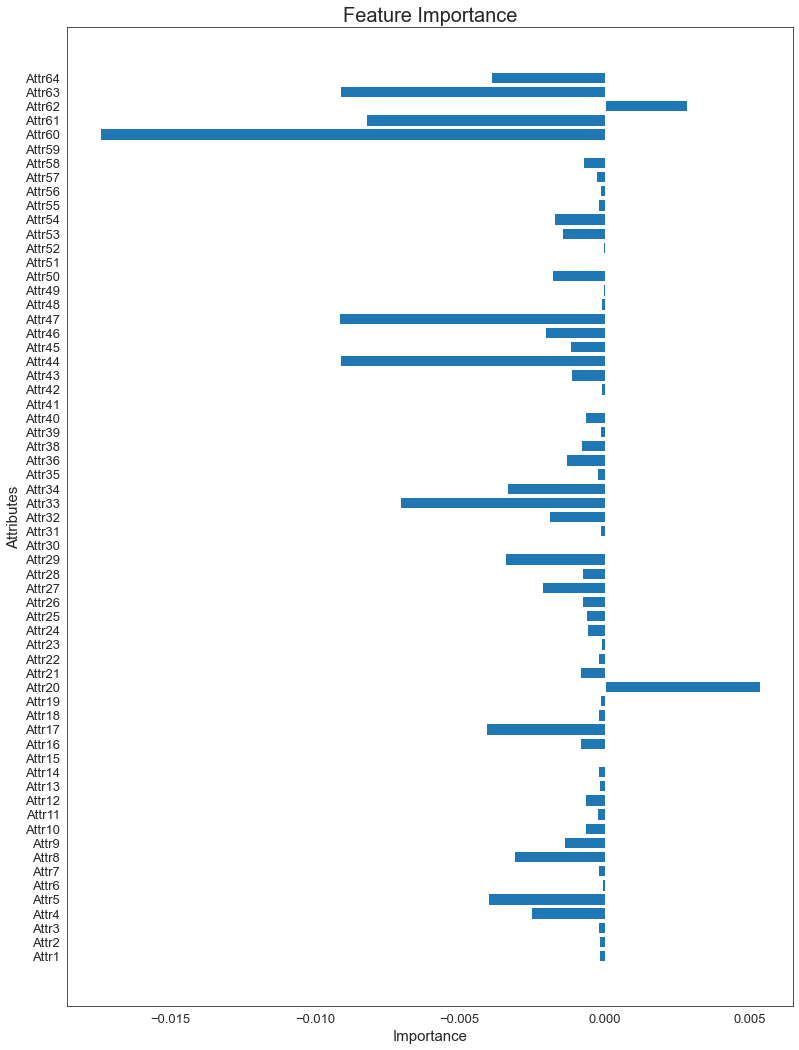

In [99]:
log_reg = LogisticRegression(solver='sag',class_weight={0:1, 1:5})
log_reg.fit(X_cimot_median_train, y_cimot_median_train)
feature_importance = log_reg.coef_[0]
features = np.asarray(X_cimot_median_train.columns)
plt.figure(figsize=(13,18))
plt.barh(features, feature_importance)
plt.title('Feature Importance', fontsize=20)
plt.xlabel('Importance', fontsize=15)
plt.ylabel('Attributes', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

#features, feature_importance

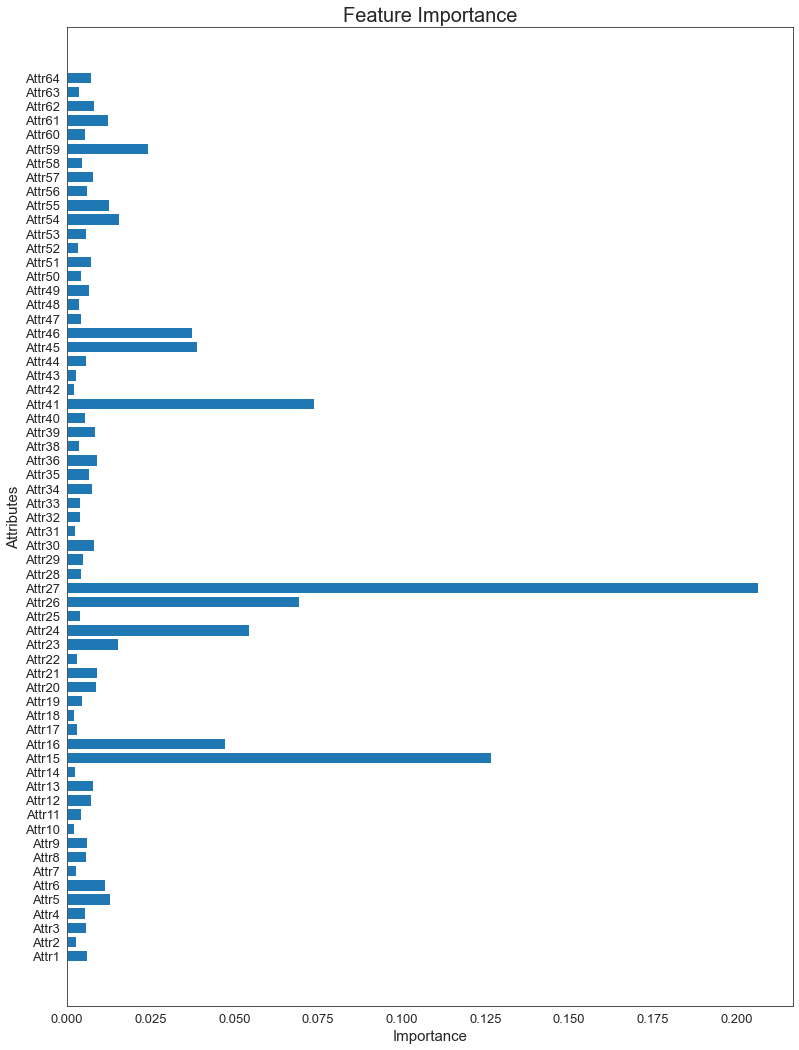

In [107]:
forest = RandomForestClassifier(n_estimators = 100, max_features = 40, max_depth = 40, class_weight={0:1,1:5}, random_state = 42)
forest.fit(X_cimot_median_train, y_cimot_median_train)

forest_importance     = forest.feature_importances_

# Graphically
plt.figure(figsize=(13,18))
plt.barh(features, forest_importance)
plt.title('Feature Importance', fontsize=20)
plt.xlabel('Importance', fontsize=15)
plt.ylabel('Attributes', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

In [102]:
features

array(['Attr1', 'Attr2', 'Attr3', 'Attr4', 'Attr5', 'Attr6', 'Attr7',
       'Attr8', 'Attr9', 'Attr10', 'Attr11', 'Attr12', 'Attr13', 'Attr14',
       'Attr15', 'Attr16', 'Attr17', 'Attr18', 'Attr19', 'Attr20',
       'Attr21', 'Attr22', 'Attr23', 'Attr24', 'Attr25', 'Attr26',
       'Attr27', 'Attr28', 'Attr29', 'Attr30', 'Attr31', 'Attr32',
       'Attr33', 'Attr34', 'Attr35', 'Attr36', 'Attr38', 'Attr39',
       'Attr40', 'Attr41', 'Attr42', 'Attr43', 'Attr44', 'Attr45',
       'Attr46', 'Attr47', 'Attr48', 'Attr49', 'Attr50', 'Attr51',
       'Attr52', 'Attr53', 'Attr54', 'Attr55', 'Attr56', 'Attr57',
       'Attr58', 'Attr59', 'Attr60', 'Attr61', 'Attr62', 'Attr63',
       'Attr64'], dtype=object)

In [103]:
X_cimot_median_train.describe()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64
count,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000,7037.000000
mean,0.054864,0.471198,0.225640,1.806433,2.290907,0.009594,0.064450,1.391147,1.415742,0.512281,0.079658,0.203547,0.074794,0.064471,991.199193,0.284406,2.435152,0.064468,0.040856,38.438057,0.944355,0.068580,0.035036,0.183361,0.384819,0.258944,1.303907,0.561961,3.925036,0.231205,0.048108,83.596780,5.118011,2.497673,0.067005,1.662516,0.607522,0.044141,0.309126,0.092536,0.045048,101.470895,55.963581,0.323400,1.190073,41.552057,0.023815,0.014642,1.371361,0.354781,0.228500,1.269242,1.462671,1435.641954,0.060437,0.125358,0.944281,0.066600,10.967398,6.970093,76.417043,5.616196,4.688952
std,0.089452,0.270815,0.285107,1.154095,70.333407,0.049318,0.103211,1.423037,0.712397,0.269904,0.109194,0.369829,0.078434,0.103204,1450.519516,0.377275,1.452264,0.103204,0.062041,30.787992,0.201407,0.103598,0.054420,0.248850,0.304718,0.344039,2.247110,0.855336,0.777218,0.232695,0.067270,52.858726,3.316098,2.589636,0.104595,0.885878,0.233389,0.065127,0.384889,0.112398,0.064354,50.612283,30.577079,0.552119,0.860776,33.837136,0.106681,0.067172,0.929662,0.227590,0.144134,0.903703,0.824774,2623.229149,0.086139,0.179595,0.083179,0.132812,7.793924,3.698264,48.525348,3.621811,3.978963
min,-0.261070,0.000000,-0.691170,0.002238,-234.890000,-0.247110,-0.273970,-2.081800,-0.000084,-0.441890,-0.275890,-0.863780,-0.177480,-0.273970,-9254.600000,-0.816780,-0.043411,-0.273970,-0.221360,-0.001439,0.393670,-0.266750,-0.221360,-0.494350,-0.565360,-0.753620,-6.581000,-2.182200,1.740300,-0.485610,-0.202040,-0.002254,-1.921900,-5.502500,-0.343140,-0.000084,-0.341870,-0.255310,-0.411990,-0.705060,-0.200860,-0.293730,0.000000,-1.324500,-0.079512,-3.706700,-0.324320,-0.279300,0.002238,0.000000,0.000000,-1.619200,-1.182200,-6680.100000,-0.229940,-0.640800,0.693380,-0.351810,0.000000,-0.014534,0.000000,-0.000156,-0.000102
25%,0.006431,0.253850,0.037855,1.040100,-31.588000,0.000000,0.008189,0.425910,1.011800,0.318410,0.018317,0.015905,0.028165,0.008222,318.820000,0.064907,1.445000,0.008222,0.007698,14.672000,0.829550,0.000000,0.006574,0.028065,0.175240,0.060738,0.288850,0.062237,3.419500,0.082236,0.012225,44.589000,2.742200,0.378990,0.007854,1.031300,0.455210,0.007527,0.055442,0.034736,0.004646,65.944000,34.278000,0.045753,0.594600,15.544000,-0.028057,-0.013815,0.753460,0.174760,0.122090,0.726900,0.992080,100.850000,0.014233,0.025273,0.905090,0.000000,5.689300,4.485800,40.432000,3.027400,2.041400
50%,0.045404,0.455845,0.205955,1.585200,3.284400,0.000000,0.054174,1.103900,1.191900,0.525320,0.071158,0.167200,0.069723,0.054229,800.905000,0.244100,2.146500,0.054229,0.034398,34.289000,0.955370,0.056921,0.028951,0.168500,0.391945,0.224400,1.071050,0.476710,3.935300,0.211230,0.041767,76.317500,4.634000,1.993500,0.055943,1.562700,0.637410,0.035714,0.190560,0.078684,0.036579,98.863500,54.405000,0.282670,1.055000,37.07

In [104]:
y_cimot_median_train.describe()

count    7037.000000
mean        0.048032
std         0.213849
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: class, dtype: float64

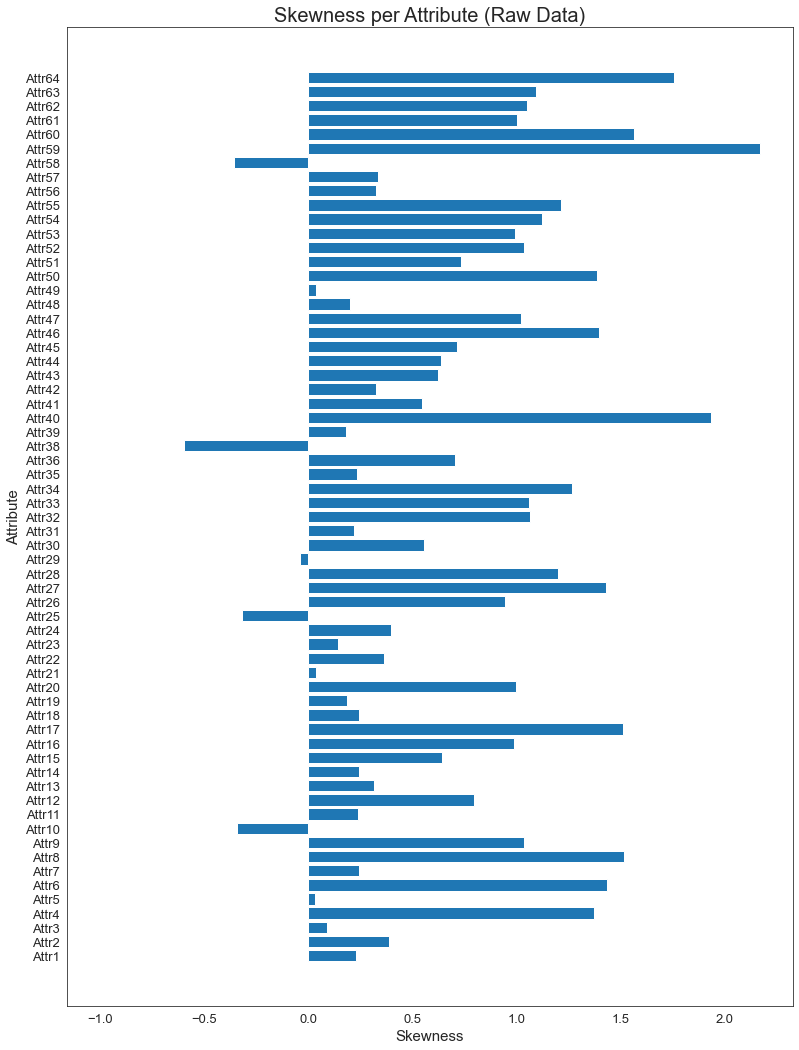

In [106]:
Skewness = X_cimot_median_train.skew().values
plt.figure(figsize=(13,18))
plt.barh(features,Skewness)
plt.plot(-1,0,"--")
plt.title('Skewness per Attribute (Raw Data)', fontsize=20)
plt.ylabel('Attribute', fontsize=15)
plt.xlabel('Skewness', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

In [108]:
model = SelectFromModel(forest, prefit=True)
X_cimot_median_train_new = model.transform(X_cimot_median_train)
X_cimot_median_train_new.shape

(7037, 9)

In [114]:
names = model.get_support()
X_cimot_median_train.columns[names]

Index(['Attr15', 'Attr16', 'Attr24', 'Attr26', 'Attr27', 'Attr41', 'Attr45',
       'Attr46', 'Attr59'],
      dtype='object')

In [115]:
model_lr = SelectFromModel(log_reg, prefit=True)
X_cimot_median_train_lr = model_lr.transform(X_cimot_median_train)
X_cimot_median_train_lr.shape

(7037, 17)

In [117]:
names_lr = model_lr.get_support()
X_cimot_median_train.columns[names_lr]

Index(['Attr4', 'Attr5', 'Attr8', 'Attr17', 'Attr20', 'Attr27', 'Attr29',
       'Attr33', 'Attr34', 'Attr44', 'Attr46', 'Attr47', 'Attr60', 'Attr61',
       'Attr62', 'Attr63', 'Attr64'],
      dtype='object')

X_cimot_median_train, X_cimot_median_test, y_cimot_median_train, y_cimot_median_test

In [118]:
data_results = []

for weight in range(1,20):
    forest = RandomForestClassifier(n_estimators = 100, max_features = 40, max_depth = 40, class_weight={0:1,1:weight}, random_state = 42)
    forest.fit(X_cimot_median_train, y_cimot_median_train)
    model = SelectFromModel(forest, prefit=True)
    recall_ = recall_score(y_cimot_median_test, forest.predict(X_cimot_median_test), average='macro')
    names = model.get_support()
    data_results.append([weight, model.transform(X_cimot_median_train).shape[1], recall_.round(decimals=2), X_cimot_median_train.columns[names].values])

In [119]:
results = pd.DataFrame(data_results, columns=['weight','predictors','recall','predictor_names'])
results

,weight,predictors,recall,predictor_names
0,1,16,0.85,"[Attr5, Attr6, Attr15, Attr20, Attr23, Attr27,..."
1,2,16,0.86,"[Attr5, Attr6, Attr15, Attr16, Attr20, Attr23,..."
2,3,13,0.88,"[Attr5, Attr6, Attr15, Attr16, Attr23, Attr24,..."
3,4,10,0.88,"[Attr15, Attr16, Attr23, Attr24, Attr26, Attr2..."
4,5,9,0.87,"[Attr15, Attr16, Attr24, Attr26, Attr27, Attr4..."
5,6,10,0.87,"[Attr15, Attr16, Attr24, Attr26, Attr27, Attr4..."
6,7,11,0.87,"[Attr15, Attr16, Attr24, Attr26, Attr27, Attr4..."
7,8,10,0.86,"[Attr15, Attr16, Attr24, Attr26, Attr27, Attr4..."
8,9,11,0.86,"[Attr15, Attr16, Attr24, Attr26, Attr27, Attr4..."
9,10,11,0.86,"[Attr15, Attr16, Attr24, Attr26, Attr27, Attr4..."


In [122]:
print("The proposed predictors to be used, based on RFC, are: ",results.iloc[3,3].tolist())
print("This is done with a weight of: ",results.iloc[3,0])

The proposed predictors to be used, based on RFC, are:  ['Attr15', 'Attr16', 'Attr23', 'Attr24', 'Attr26', 'Attr27', 'Attr41', 'Attr45', 'Attr46', 'Attr59']
This is done with a weight of:  4


X_icimedian_train, X_icimedian_test, y_icimedian_train, y_icimedian_test

In [123]:
data_results_ici = []

for weight in range(1,20):
    forest_ici = RandomForestClassifier(n_estimators = 100, max_features = 40, max_depth = 40, class_weight={0:1,1:weight}, random_state = 42)
    forest_ici.fit(X_icimedian_train, y_icimedian_train)
    model_ici = SelectFromModel(forest_ici, prefit=True)
    recall_ = recall_score(y_icimedian_test, forest_ici.predict(X_icimedian_test), average='macro')
    names = model_ici.get_support()
    data_results_ici.append([weight, model_ici.transform(X_icimedian_train).shape[1], recall_.round(decimals=2), X_icimedian_train.columns[names].values])

In [124]:
results_ici = pd.DataFrame(data_results_ici, columns=['weight','predictors','recall','predictor_names'])
results_ici

,weight,predictors,recall,predictor_names
0,1,16,0.64,"[Attr5, Attr15, Attr21, Attr24, Attr26, Attr27..."
1,2,18,0.63,"[Attr5, Attr15, Attr16, Attr21, Attr24, Attr26..."
2,3,15,0.63,"[Attr5, Attr13, Attr15, Attr16, Attr21, Attr24..."
3,4,15,0.64,"[Attr5, Attr13, Attr15, Attr16, Attr21, Attr24..."
4,5,15,0.64,"[Attr5, Attr13, Attr15, Attr16, Attr21, Attr24..."
5,6,15,0.64,"[Attr5, Attr13, Attr15, Attr16, Attr21, Attr24..."
6,7,15,0.64,"[Attr5, Attr13, Attr15, Attr16, Attr21, Attr24..."
7,8,16,0.64,"[Attr5, Attr13, Attr15, Attr16, Attr21, Attr24..."
8,9,16,0.64,"[Attr5, Attr13, Attr15, Attr16, Attr21, Attr24..."
9,10,15,0.64,"[Attr5, Attr13, Attr16, Attr21, Attr24, Attr25..."


In [125]:
print("The proposed predictors to be used, based on RFC, are: ",results_ici.iloc[10,3].tolist())
print("This is done with a weight of: ",results_ici.iloc[10,0])

The proposed predictors to be used, based on RFC, are:  ['Attr5', 'Attr13', 'Attr16', 'Attr21', 'Attr24', 'Attr25', 'Attr26', 'Attr27', 'Attr34', 'Attr40', 'Attr41', 'Attr45', 'Attr46', 'Attr58']
This is done with a weight of:  11
